In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 20g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[21:45:04.960] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_us  # 400k/9.4k -> 60k/1.1k -> 53k/774
# countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 168,  20  # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # Familiar set
# recs_at_least, num_species, num_recs =  20, 336,  20  # us[774/53k -> 528/51k -> 336/33k -> 336/ 6.7k -> 336/ 6.7k]  # Scale species
# recs_at_least, num_species, num_recs =  10, 168,  20  # ca[334/35k ->                                             ]  # Class imbalance
recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   50  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   20  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   10  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,    5  # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          774/52707 (sp/recs)
(downloaded)       774/52702 (sp/recs)
recs_at_least      774/52702 (sp/recs)
num_species        168/11321 (sp/recs)


num_recs            168/2662 (sp/recs)
recs ≥ 2            159/2653 (sp/recs)


'sp[159], recs[2653]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,74284,2653,2653,1,NaN,NaN,True,True,True,True,True
species,category,140621,2653,2653,159,NaN,NaN,HAWD,SESA,WIFL,LALO,CHMU
id,int64,74284,2653,2653,2653,208945.430,109064.785,624,131039,197792,301235,417184
sci_name,category,178657,2653,2653,159,NaN,NaN,Anas wyvilliana,Calidris pusilla,Empidonax traillii,Calcarius lapponicus,Lonchura atricapilla
com_name,category,172990,2653,2653,159,NaN,NaN,Hawaiian Duck,Semipalmated Sandpiper,Willow Flycatcher,Lapland Longspur,Chestnut Munia
subspecies,object,134068,2653,2653,157,NaN,NaN,,,,,zelotes
recordist,object,165883,2653,2653,275,NaN,NaN,Aaron Pietsch,Elias Aristides Elias,Matthew Halley,Peter Boesman,william stecher
country,object,160566,2653,2653,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,246352,2653,2653,1400,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Cougar Mountain Regional Wildland Park, King Co., Washington","Lostwood NWR, Burke County, North Dakota","Sabal Palm Sanctuary, Brownsville, Texas","west end of Monument Rd, Tijuana River Valley, San Diego Co, California"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
AWPE,367093,True,AWPE,36292,Pelecanus erythrorhynchos,American White Pelican,,Andrew Spencer,United States,"Riverside Reservoir, Weld Co., Colorado",40.3,-104.0,call,A,2009-06-27 00:00:00,06:20,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/36292,//www.xeno-canto.org/36292/download
SPSA,252913,True,SPSA,157635,Actitis macularius,Spotted Sandpiper,,Ian Cruickshank,Canada,"Watson Lake, Yukon Territory",60.1,-129.0,call,B,2010-07-06 00:00:00,10:00,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/157635,//www.xeno-canto.org/157635/download
FEPO,48286,True,FEPO,368470,Glaucidium brasilianum,Ferruginous Pygmy Owl,,Dan Lane,United States,"Edinburg, Hidalgo, Texas",26.6,-98.1,song,A,2017-04-27 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/368470,//www.xeno-canto.org/368470/download
COPA,57173,True,COPA,359450,Nyctidromus albicollis,Pauraque,,Paul Marvin,United States,"Falcon County Park (near Falcon State Park), Starr Co, Texas",26.6,-99.1,flight call,B,2016-12-22 00:00:00,06:43,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/359450,//www.xeno-canto.org/359450/download
BBEH,192325,True,BBEH,221044,Amazilia yucatanensis,Buff-bellied Hummingbird,,Peter Boesman,Mexico,"Gomez Farias area, Tamaulipas",23.0,-99.1,song,B,2000-06-05 00:00:00,08:00,by-nc-nd,4.0,//creativecommons.org/licenses/by-nc-nd/4.0/,https://www.xeno-canto.org/221044,//www.xeno-canto.org/221044/download
RBRO,109922,True,RBRO,305399,Turdus rufopalliatus,Rufous-backed Thrush,,Manuel Grosselet,Mexico,"Mx, Distrito Federal, Lomas de Bezares, Calle Colina",19.4,-99.2,call,A,2016-03-02 00:00:00,07:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/305399,//www.xeno-canto.org/305399/download
RWSP,296942,True,RWSP,111634,Peucaea carpalis,Rufous-winged Sparrow,,Richard E Webster,United States,"Buenos Aires National Wildlife Refuge, Pima County, Arizona",31.6,-111.0,song,A,2010-08-11 00:00:00,07:08,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/111634,//www.xeno-canto.org/111634/download
FOSP,239385,True,FOSP,171773,Passerella iliaca,Fox Sparrow,,Derek Buchner,United States,"Seattle, King County, Washington",47.7,-122.0,song,B,2014-03-31 00:00:00,08:35,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/171773,//www.xeno-canto.org/171773/download
VESP,61321,True,VESP,355237,Pooecetes gramineus,Vesper Sparrow,,Thomas Magarian,United States,"Kevin Rim, Toole County, Montana",48.8,-112.0,call,no score,2015-08-10 00:00:00,06:47,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/355237,//www.xeno-canto.org/355237/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    f"{len(xcs_paths)}/{len(xcs)}",
    # xcs_paths[:2],
)

'2653/2653'

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,135303,2653,2653,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,140621,2653,2653,159,NaN,NaN,HAWD,SESA,WIFL,LALO,CHMU
species_com_name,category,172959,2653,2653,159,NaN,NaN,Hawaiian Duck,Semipalmated Sandpiper,Willow Flycatcher,Lapland Longspur,Chestnut Munia
species_query,object,140621,2653,2653,159,NaN,NaN,ABTO,COME,KAEL,RBSA,marcro1
duration_s,float64,63672,2653,2653,2459,6.033e+01,1.767e+02,0.957,14.5,30.8,62.5,5.85e+03
samples_mb,float64,63672,2653,2653,2461,2.548e+00,7.446e+00,0.0403,0.609,1.3,2.63,246
samples_n,int64,74284,2653,2653,2461,1.336e+06,3.904e+06,21103,319104,682781,1378944,129029566
basename,object,143262,2653,2653,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,191542,2653,2653,159,NaN,NaN,Hawaiian Duck - HAWD,Semipalmated Sandpiper - SESA,Willow Flycatcher - WIFL,Lapland Longspur - LALO,Chestnut Munia - CHMU


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,HAWD,Hawaiian Duck,HAWD,57.30,2.410,1263744,audio,Hawaiian Duck - HAWD,xc/data/HAWD/234982/audio,xc/data/HAWD/234982/audio.mp3
1,xc,HAWD,Hawaiian Duck,HAWD,19.70,0.828,434304,audio,Hawaiian Duck - HAWD,xc/data/HAWD/234981/audio,xc/data/HAWD/234981/audio.mp3
2,xc,HAWD,Hawaiian Duck,HAWD,18.30,0.770,403776,audio,Hawaiian Duck - HAWD,xc/data/HAWD/235000/audio,xc/data/HAWD/235000/audio.mp3
3,xc,HAWD,Hawaiian Duck,HAWD,25.70,1.080,566784,audio,Hawaiian Duck - HAWD,xc/data/HAWD/235005/audio,xc/data/HAWD/235005/audio.mp3
4,xc,REDH,Redhead,REDH,6.61,0.278,145728,audio,Redhead - REDH,xc/data/REDH/70557/audio,xc/data/REDH/70557/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plots below (~7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Hawaiian Duck - HAWD,•••••••••••• /20
1,Redhead - REDH,•••••••••••••••••••••••••••••••••••••••••••••••• /20
2,King Eider - KIEI,••••••••••••••••••••••••••• /20
3,Long-tailed Duck - LTDU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Bufflehead - BUFF,•••••••••••••••••••••••••••••••••••••••••• /20
5,Common Goldeneye - COGO,•••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Common Merganser - COME,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Plain Chachalaca - PLCH,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Scaled Quail - SCQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
# Num recs loaded for training + total num available [slow: ~7s]
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .assign(recs_n=1).groupby(['species', 'species_longhand'])['recs_n'].sum().reset_index()
    .set_index('species')
    # [:100]
    .join(how='left', other=(xc.metadata
        .assign(total_n=1).groupby('species')['total_n'].sum().reset_index()
        .set_index('species')
    ))
    .reset_index()
    .pipe(ggplot)
    + aes(x='species_longhand')
    + geom_col(aes(y='total_n'), fill='darkgray')
    + geom_col(aes(y='recs_n'), fill=scale_color_cmap(mpl.cm.tab10).palette(0))
    # + geom_point(aes(y='total_n'), color='darkgray')
    # + geom_point(aes(y='recs_n'), color=scale_color_cmap(mpl.cm.tab10).palette(0))
    + expand_limits(y=0)
    + coord_flip()
    + theme(axis_text_y=element_text(size=4))
    + theme_figsize(width=18, aspect_ratio=3/2)
    + ggtitle('Num recs loaded for training + total num available')
)

[skip]

In [ ]:
# Plot recs with duration [slow: ~7s]
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.3s

[                                                                                          ] | 0% Completed |  0.4s

[                                                                                          ] | 0% Completed |  0.6s

[                                                                                          ] | 0% Completed |  0.7s

[                                                                                          ] | 0% Completed |  0.8s

[                                                                                          ] | 0% Completed |  0.9s

[##                                                                                        ] | 2% Completed |  1.0s

[###                                                                                       ] | 3% Completed |  1.1s

[###                                                                                       ] | 3% Completed |  1.3s

[###                                                                                       ] | 3% Completed |  1.4s

[###                                                                                       ] | 3% Completed |  1.5s

[###                                                                                       ] | 3% Completed |  1.6s

[####                                                                                      ] | 5% Completed |  1.7s

[####                                                                                      ] | 5% Completed |  1.8s

[####                                                                                      ] | 5% Completed |  1.9s

[#####                                                                                     ] | 6% Completed |  2.0s

[#####                                                                                     ] | 6% Completed |  2.1s

[######                                                                                    ] | 7% Completed |  2.2s

[######                                                                                    ] | 7% Completed |  2.3s

[######                                                                                    ] | 7% Completed |  2.4s

[######                                                                                    ] | 7% Completed |  2.5s

[#######                                                                                   ] | 8% Completed |  2.6s

[#######                                                                                   ] | 8% Completed |  2.7s

[#########                                                                                 ] | 10% Completed |  2.8s

[###########                                                                               ] | 12% Completed |  3.0s

[#############                                                                             ] | 15% Completed |  3.1s

[###############                                                                           ] | 17% Completed |  3.2s

[################                                                                          ] | 18% Completed |  3.4s

[################                                                                          ] | 18% Completed |  3.5s

[################                                                                          ] | 18% Completed |  3.6s

[################                                                                          ] | 18% Completed |  3.7s

[################                                                                          ] | 18% Completed |  3.8s

[################                                                                          ] | 18% Completed |  3.9s

[################                                                                          ] | 18% Completed |  4.0s

[################                                                                          ] | 18% Completed |  4.1s

[################                                                                          ] | 18% Completed |  4.2s

[################                                                                          ] | 18% Completed |  4.3s

[################                                                                          ] | 18% Completed |  4.4s

[################                                                                          ] | 18% Completed |  4.5s

[################                                                                          ] | 18% Completed |  4.6s

[################                                                                          ] | 18% Completed |  4.7s

[################                                                                          ] | 18% Completed |  4.8s

[################                                                                          ] | 18% Completed |  4.9s

[################                                                                          ] | 18% Completed |  5.0s

[################                                                                          ] | 18% Completed |  5.1s

[################                                                                          ] | 18% Completed |  5.2s

[################                                                                          ] | 18% Completed |  5.3s

[################                                                                          ] | 18% Completed |  5.4s

[################                                                                          ] | 18% Completed |  5.5s

[################                                                                          ] | 18% Completed |  5.6s

[################                                                                          ] | 18% Completed |  5.7s

[################                                                                          ] | 18% Completed |  5.9s

[################                                                                          ] | 18% Completed |  6.0s

[################                                                                          ] | 18% Completed |  6.1s

[################                                                                          ] | 18% Completed |  6.2s

[################                                                                          ] | 18% Completed |  6.3s

[################                                                                          ] | 18% Completed |  6.4s

[################                                                                          ] | 18% Completed |  6.5s

[################                                                                          ] | 18% Completed |  6.6s

[################                                                                          ] | 18% Completed |  6.7s

[################                                                                          ] | 18% Completed |  6.8s

[################                                                                          ] | 18% Completed |  6.9s

[################                                                                          ] | 18% Completed |  7.0s

[################                                                                          ] | 18% Completed |  7.1s

[################                                                                          ] | 18% Completed |  7.2s

[################                                                                          ] | 18% Completed |  7.3s

[################                                                                          ] | 18% Completed |  7.4s

[################                                                                          ] | 18% Completed |  7.5s

[##################                                                                        ] | 20% Completed |  7.6s

[##################                                                                        ] | 20% Completed |  7.7s

[##################                                                                        ] | 20% Completed |  7.8s

[##################                                                                        ] | 20% Completed |  7.9s

[##################                                                                        ] | 20% Completed |  8.0s

[##################                                                                        ] | 20% Completed |  8.1s

[##################                                                                        ] | 20% Completed |  8.2s

[##################                                                                        ] | 20% Completed |  8.3s

[##################                                                                        ] | 20% Completed |  8.4s

[##################                                                                        ] | 20% Completed |  8.5s

[##################                                                                        ] | 20% Completed |  8.6s

[##################                                                                        ] | 20% Completed |  8.7s

[##################                                                                        ] | 20% Completed |  8.8s

[##################                                                                        ] | 20% Completed |  8.9s

[##################                                                                        ] | 20% Completed |  9.0s

[##################                                                                        ] | 20% Completed |  9.1s

[##################                                                                        ] | 20% Completed |  9.2s

[##################                                                                        ] | 20% Completed |  9.4s

[##################                                                                        ] | 20% Completed |  9.5s

[##################                                                                        ] | 20% Completed |  9.6s

[##################                                                                        ] | 20% Completed |  9.7s

[##################                                                                        ] | 20% Completed |  9.8s

[##################                                                                        ] | 20% Completed |  9.9s

[##################                                                                        ] | 20% Completed | 10.0s

[##################                                                                        ] | 20% Completed | 10.1s

[##################                                                                        ] | 20% Completed | 10.2s

[##################                                                                        ] | 20% Completed | 10.3s

[##################                                                                        ] | 20% Completed | 10.4s

[##################                                                                        ] | 20% Completed | 10.5s

[##################                                                                        ] | 20% Completed | 10.6s

[##################                                                                        ] | 20% Completed | 10.7s

[##################                                                                        ] | 20% Completed | 10.8s

[##################                                                                        ] | 20% Completed | 10.9s

[##################                                                                        ] | 20% Completed | 11.0s

[##################                                                                        ] | 20% Completed | 11.1s

[##################                                                                        ] | 20% Completed | 11.2s

[##################                                                                        ] | 20% Completed | 11.3s

[##################                                                                        ] | 20% Completed | 11.4s

[##################                                                                        ] | 20% Completed | 11.5s

[##################                                                                        ] | 20% Completed | 11.6s

[##################                                                                        ] | 20% Completed | 11.7s

[##################                                                                        ] | 20% Completed | 11.8s

[##################                                                                        ] | 20% Completed | 11.9s

[##################                                                                        ] | 20% Completed | 12.0s

[##################                                                                        ] | 20% Completed | 12.1s

[##################                                                                        ] | 20% Completed | 12.2s

[##################                                                                        ] | 20% Completed | 12.3s

[##################                                                                        ] | 20% Completed | 12.4s

[##################                                                                        ] | 20% Completed | 12.5s

[##################                                                                        ] | 20% Completed | 12.7s

[##################                                                                        ] | 20% Completed | 12.8s

[##################                                                                        ] | 20% Completed | 12.9s

[##################                                                                        ] | 20% Completed | 13.0s

[##################                                                                        ] | 20% Completed | 13.1s

[##################                                                                        ] | 20% Completed | 13.2s

[##################                                                                        ] | 20% Completed | 13.3s

[##################                                                                        ] | 20% Completed | 13.4s

[##################                                                                        ] | 20% Completed | 13.5s

[##################                                                                        ] | 20% Completed | 13.6s

[##################                                                                        ] | 20% Completed | 13.7s

[##################                                                                        ] | 20% Completed | 13.8s

[##################                                                                        ] | 20% Completed | 13.9s

[##################                                                                        ] | 20% Completed | 14.0s

[##################                                                                        ] | 20% Completed | 14.1s

[##################                                                                        ] | 20% Completed | 14.2s

[##################                                                                        ] | 20% Completed | 14.3s

[##################                                                                        ] | 20% Completed | 14.4s

[##################                                                                        ] | 20% Completed | 14.5s

[##################                                                                        ] | 20% Completed | 14.6s

[##################                                                                        ] | 20% Completed | 14.7s

[##################                                                                        ] | 20% Completed | 14.8s

[##################                                                                        ] | 20% Completed | 14.9s

[##################                                                                        ] | 20% Completed | 15.0s

[##################                                                                        ] | 20% Completed | 15.1s

[##################                                                                        ] | 20% Completed | 15.2s

[##################                                                                        ] | 20% Completed | 15.3s

[##################                                                                        ] | 20% Completed | 15.4s

[##################                                                                        ] | 20% Completed | 15.5s

[##################                                                                        ] | 20% Completed | 15.6s

[##################                                                                        ] | 20% Completed | 15.7s

[##################                                                                        ] | 20% Completed | 15.9s

[##################                                                                        ] | 20% Completed | 16.0s

[##################                                                                        ] | 20% Completed | 16.1s

[##################                                                                        ] | 20% Completed | 16.2s

[##################                                                                        ] | 20% Completed | 16.3s

[##################                                                                        ] | 20% Completed | 16.4s

[##################                                                                        ] | 20% Completed | 16.5s

[##################                                                                        ] | 20% Completed | 16.6s

[##################                                                                        ] | 20% Completed | 16.7s

[##################                                                                        ] | 20% Completed | 16.8s

[##################                                                                        ] | 20% Completed | 16.9s

[###################                                                                       ] | 21% Completed | 17.0s

[###################                                                                       ] | 21% Completed | 17.1s

[###################                                                                       ] | 21% Completed | 17.2s

[###################                                                                       ] | 21% Completed | 17.3s

[###################                                                                       ] | 21% Completed | 17.4s

[###################                                                                       ] | 21% Completed | 17.5s

[###################                                                                       ] | 21% Completed | 17.6s

[###################                                                                       ] | 21% Completed | 17.7s

[###################                                                                       ] | 21% Completed | 17.8s

[###################                                                                       ] | 21% Completed | 17.9s

[###################                                                                       ] | 21% Completed | 18.0s

[###################                                                                       ] | 21% Completed | 18.1s

[###################                                                                       ] | 21% Completed | 18.2s

[###################                                                                       ] | 21% Completed | 18.3s

[###################                                                                       ] | 21% Completed | 18.4s

[###################                                                                       ] | 21% Completed | 18.5s

[###################                                                                       ] | 21% Completed | 18.6s

[###################                                                                       ] | 21% Completed | 18.7s

[###################                                                                       ] | 21% Completed | 18.8s

[###################                                                                       ] | 21% Completed | 18.9s

[###################                                                                       ] | 21% Completed | 19.0s

[###################                                                                       ] | 21% Completed | 19.2s

[###################                                                                       ] | 21% Completed | 19.3s

[###################                                                                       ] | 21% Completed | 19.4s

[###################                                                                       ] | 21% Completed | 19.5s

[###################                                                                       ] | 21% Completed | 19.6s

[###################                                                                       ] | 21% Completed | 19.7s

[###################                                                                       ] | 21% Completed | 19.8s

[###################                                                                       ] | 21% Completed | 19.9s

[###################                                                                       ] | 21% Completed | 20.0s

[###################                                                                       ] | 21% Completed | 20.1s

[###################                                                                       ] | 21% Completed | 20.2s

[###################                                                                       ] | 21% Completed | 20.3s

[###################                                                                       ] | 21% Completed | 20.4s

[###################                                                                       ] | 21% Completed | 20.5s

[###################                                                                       ] | 21% Completed | 20.6s

[###################                                                                       ] | 21% Completed | 20.7s

[###################                                                                       ] | 21% Completed | 20.8s

[###################                                                                       ] | 21% Completed | 20.9s

[###################                                                                       ] | 21% Completed | 21.0s

[###################                                                                       ] | 21% Completed | 21.1s

[###################                                                                       ] | 21% Completed | 21.2s

[###################                                                                       ] | 21% Completed | 21.3s

[###################                                                                       ] | 21% Completed | 21.4s

[###################                                                                       ] | 21% Completed | 21.5s

[###################                                                                       ] | 21% Completed | 21.6s

[###################                                                                       ] | 21% Completed | 21.7s

[###################                                                                       ] | 21% Completed | 21.8s

[###################                                                                       ] | 21% Completed | 21.9s

[###################                                                                       ] | 21% Completed | 22.0s

[####################                                                                      ] | 22% Completed | 22.1s

[####################                                                                      ] | 22% Completed | 22.2s

[####################                                                                      ] | 22% Completed | 22.4s

[####################                                                                      ] | 22% Completed | 22.5s

[####################                                                                      ] | 22% Completed | 22.6s

[####################                                                                      ] | 22% Completed | 22.7s

[####################                                                                      ] | 22% Completed | 22.8s

[####################                                                                      ] | 22% Completed | 22.9s

[####################                                                                      ] | 22% Completed | 23.0s

[####################                                                                      ] | 22% Completed | 23.1s

[####################                                                                      ] | 22% Completed | 23.2s

[####################                                                                      ] | 22% Completed | 23.3s

[####################                                                                      ] | 22% Completed | 23.4s

[####################                                                                      ] | 22% Completed | 23.5s

[#####################                                                                     ] | 23% Completed | 23.6s

[#####################                                                                     ] | 23% Completed | 23.7s

[#####################                                                                     ] | 23% Completed | 23.8s

[#####################                                                                     ] | 23% Completed | 23.9s

[#####################                                                                     ] | 23% Completed | 24.0s

[#####################                                                                     ] | 23% Completed | 24.1s

[#####################                                                                     ] | 23% Completed | 24.2s

[#####################                                                                     ] | 23% Completed | 24.3s

[#####################                                                                     ] | 23% Completed | 24.4s

[#####################                                                                     ] | 23% Completed | 24.5s

[#####################                                                                     ] | 23% Completed | 24.6s

[#####################                                                                     ] | 23% Completed | 24.7s

[#####################                                                                     ] | 23% Completed | 24.8s

[#####################                                                                     ] | 23% Completed | 24.9s

[#####################                                                                     ] | 23% Completed | 25.0s

[#####################                                                                     ] | 23% Completed | 25.1s

[#####################                                                                     ] | 23% Completed | 25.3s

[#####################                                                                     ] | 23% Completed | 25.4s

[#####################                                                                     ] | 23% Completed | 25.5s

[#####################                                                                     ] | 23% Completed | 25.6s

[#####################                                                                     ] | 23% Completed | 25.7s

[######################                                                                    ] | 25% Completed | 25.8s

[######################                                                                    ] | 25% Completed | 25.9s

[######################                                                                    ] | 25% Completed | 26.0s

[######################                                                                    ] | 25% Completed | 26.1s

[######################                                                                    ] | 25% Completed | 26.2s

[######################                                                                    ] | 25% Completed | 26.3s

[######################                                                                    ] | 25% Completed | 26.4s

[######################                                                                    ] | 25% Completed | 26.5s

[######################                                                                    ] | 25% Completed | 26.6s

[######################                                                                    ] | 25% Completed | 26.7s

[######################                                                                    ] | 25% Completed | 26.8s

[######################                                                                    ] | 25% Completed | 26.9s

[######################                                                                    ] | 25% Completed | 27.0s

[######################                                                                    ] | 25% Completed | 27.1s

[######################                                                                    ] | 25% Completed | 27.2s

[######################                                                                    ] | 25% Completed | 27.3s

[######################                                                                    ] | 25% Completed | 27.4s

[######################                                                                    ] | 25% Completed | 27.5s

[######################                                                                    ] | 25% Completed | 27.6s

[######################                                                                    ] | 25% Completed | 27.7s

[######################                                                                    ] | 25% Completed | 27.8s

[######################                                                                    ] | 25% Completed | 27.9s

[######################                                                                    ] | 25% Completed | 28.0s

[######################                                                                    ] | 25% Completed | 28.1s

[######################                                                                    ] | 25% Completed | 28.2s

[######################                                                                    ] | 25% Completed | 28.3s

[######################                                                                    ] | 25% Completed | 28.4s

[######################                                                                    ] | 25% Completed | 28.5s

[######################                                                                    ] | 25% Completed | 28.7s

[######################                                                                    ] | 25% Completed | 28.8s

[######################                                                                    ] | 25% Completed | 28.9s

[######################                                                                    ] | 25% Completed | 29.0s

[######################                                                                    ] | 25% Completed | 29.1s

[######################                                                                    ] | 25% Completed | 29.2s

[######################                                                                    ] | 25% Completed | 29.3s

[######################                                                                    ] | 25% Completed | 29.4s

[######################                                                                    ] | 25% Completed | 29.5s

[######################                                                                    ] | 25% Completed | 29.6s

[######################                                                                    ] | 25% Completed | 29.7s

[######################                                                                    ] | 25% Completed | 29.8s

[######################                                                                    ] | 25% Completed | 29.9s

[######################                                                                    ] | 25% Completed | 30.0s

[######################                                                                    ] | 25% Completed | 30.1s

[######################                                                                    ] | 25% Completed | 30.2s

[######################                                                                    ] | 25% Completed | 30.3s

[######################                                                                    ] | 25% Completed | 30.4s

[######################                                                                    ] | 25% Completed | 30.5s

[######################                                                                    ] | 25% Completed | 30.6s

[######################                                                                    ] | 25% Completed | 30.7s

[######################                                                                    ] | 25% Completed | 30.8s

[######################                                                                    ] | 25% Completed | 30.9s

[######################                                                                    ] | 25% Completed | 31.0s

[######################                                                                    ] | 25% Completed | 31.1s

[######################                                                                    ] | 25% Completed | 31.2s

[######################                                                                    ] | 25% Completed | 31.4s

[######################                                                                    ] | 25% Completed | 31.5s

[######################                                                                    ] | 25% Completed | 31.6s

[######################                                                                    ] | 25% Completed | 31.7s

[######################                                                                    ] | 25% Completed | 31.8s

[#######################                                                                   ] | 26% Completed | 31.9s

[#########################                                                                 ] | 28% Completed | 32.0s

[###########################                                                               ] | 30% Completed | 32.1s

[############################                                                              ] | 31% Completed | 32.2s

[#############################                                                             ] | 32% Completed | 32.4s

[#############################                                                             ] | 32% Completed | 32.5s

[#############################                                                             ] | 32% Completed | 32.6s

[#############################                                                             ] | 32% Completed | 32.7s

[#############################                                                             ] | 32% Completed | 32.8s

[#############################                                                             ] | 32% Completed | 32.9s

[#############################                                                             ] | 32% Completed | 33.0s

[#############################                                                             ] | 32% Completed | 33.1s

[#############################                                                             ] | 32% Completed | 33.2s

[##############################                                                            ] | 33% Completed | 33.3s

[##############################                                                            ] | 33% Completed | 33.4s

[##############################                                                            ] | 33% Completed | 33.5s

[##############################                                                            ] | 33% Completed | 33.6s

[##############################                                                            ] | 33% Completed | 33.7s

[##############################                                                            ] | 33% Completed | 33.8s

[##############################                                                            ] | 33% Completed | 34.0s

[##############################                                                            ] | 33% Completed | 34.1s

[##############################                                                            ] | 33% Completed | 34.2s

[##############################                                                            ] | 33% Completed | 34.3s

[##############################                                                            ] | 33% Completed | 34.4s

[##############################                                                            ] | 33% Completed | 34.5s

[##############################                                                            ] | 33% Completed | 34.6s

[##############################                                                            ] | 33% Completed | 34.7s

[##############################                                                            ] | 33% Completed | 34.8s

[##############################                                                            ] | 33% Completed | 34.9s

[##############################                                                            ] | 33% Completed | 35.0s

[##############################                                                            ] | 33% Completed | 35.1s

[##############################                                                            ] | 33% Completed | 35.2s

[##############################                                                            ] | 33% Completed | 35.3s

[##############################                                                            ] | 33% Completed | 35.4s

[##############################                                                            ] | 33% Completed | 35.5s

[##############################                                                            ] | 33% Completed | 35.6s

[##############################                                                            ] | 33% Completed | 35.7s

[##############################                                                            ] | 33% Completed | 35.8s

[##############################                                                            ] | 33% Completed | 35.9s

[##############################                                                            ] | 33% Completed | 36.0s

[##############################                                                            ] | 33% Completed | 36.1s

[##############################                                                            ] | 33% Completed | 36.2s

[##############################                                                            ] | 33% Completed | 36.3s

[##############################                                                            ] | 33% Completed | 36.4s

[##############################                                                            ] | 33% Completed | 36.5s

[##############################                                                            ] | 33% Completed | 36.6s

[##############################                                                            ] | 33% Completed | 36.7s

[##############################                                                            ] | 33% Completed | 36.8s

[##############################                                                            ] | 33% Completed | 36.9s

[##############################                                                            ] | 33% Completed | 37.0s

[##############################                                                            ] | 33% Completed | 37.1s

[##############################                                                            ] | 33% Completed | 37.2s

[##############################                                                            ] | 33% Completed | 37.4s

[##############################                                                            ] | 33% Completed | 37.5s

[##############################                                                            ] | 33% Completed | 37.6s

[##############################                                                            ] | 33% Completed | 37.7s

[##############################                                                            ] | 33% Completed | 37.8s

[##############################                                                            ] | 33% Completed | 37.9s

[##############################                                                            ] | 33% Completed | 38.0s

[##############################                                                            ] | 33% Completed | 38.1s

[##############################                                                            ] | 33% Completed | 38.2s

[##############################                                                            ] | 33% Completed | 38.3s

[##############################                                                            ] | 33% Completed | 38.4s

[##############################                                                            ] | 33% Completed | 38.5s

[##############################                                                            ] | 33% Completed | 38.6s

[##############################                                                            ] | 33% Completed | 38.7s

[##############################                                                            ] | 33% Completed | 38.8s

[##############################                                                            ] | 33% Completed | 38.9s

[##############################                                                            ] | 33% Completed | 39.0s

[##############################                                                            ] | 33% Completed | 39.1s

[##############################                                                            ] | 33% Completed | 39.2s

[##############################                                                            ] | 33% Completed | 39.3s

[##############################                                                            ] | 33% Completed | 39.4s

[##############################                                                            ] | 33% Completed | 39.5s

[###############################                                                           ] | 35% Completed | 39.6s

[###############################                                                           ] | 35% Completed | 39.7s

[###############################                                                           ] | 35% Completed | 39.8s

[###############################                                                           ] | 35% Completed | 39.9s

[###############################                                                           ] | 35% Completed | 40.0s

[###############################                                                           ] | 35% Completed | 40.1s

[###############################                                                           ] | 35% Completed | 40.2s

[###############################                                                           ] | 35% Completed | 40.4s

[###############################                                                           ] | 35% Completed | 40.5s

[###############################                                                           ] | 35% Completed | 40.6s

[###############################                                                           ] | 35% Completed | 40.7s

[###############################                                                           ] | 35% Completed | 40.8s

[###############################                                                           ] | 35% Completed | 40.9s

[###############################                                                           ] | 35% Completed | 41.0s

[###############################                                                           ] | 35% Completed | 41.1s

[###############################                                                           ] | 35% Completed | 41.2s

[###############################                                                           ] | 35% Completed | 41.3s

[###############################                                                           ] | 35% Completed | 41.4s

[###############################                                                           ] | 35% Completed | 41.5s

[###############################                                                           ] | 35% Completed | 41.6s

[###############################                                                           ] | 35% Completed | 41.7s

[###############################                                                           ] | 35% Completed | 41.8s

[###############################                                                           ] | 35% Completed | 41.9s

[###############################                                                           ] | 35% Completed | 42.0s

[###############################                                                           ] | 35% Completed | 42.1s

[###############################                                                           ] | 35% Completed | 42.2s

[###############################                                                           ] | 35% Completed | 42.3s

[###############################                                                           ] | 35% Completed | 42.4s

[###############################                                                           ] | 35% Completed | 42.5s

[###############################                                                           ] | 35% Completed | 42.6s

[###############################                                                           ] | 35% Completed | 42.7s

[###############################                                                           ] | 35% Completed | 42.8s

[###############################                                                           ] | 35% Completed | 42.9s

[################################                                                          ] | 36% Completed | 43.0s

[################################                                                          ] | 36% Completed | 43.1s

[################################                                                          ] | 36% Completed | 43.2s

[################################                                                          ] | 36% Completed | 43.3s

[################################                                                          ] | 36% Completed | 43.4s

[################################                                                          ] | 36% Completed | 43.5s

[################################                                                          ] | 36% Completed | 43.6s

[################################                                                          ] | 36% Completed | 43.7s

[################################                                                          ] | 36% Completed | 43.9s

[################################                                                          ] | 36% Completed | 44.0s

[################################                                                          ] | 36% Completed | 44.1s

[################################                                                          ] | 36% Completed | 44.2s

[################################                                                          ] | 36% Completed | 44.3s

[################################                                                          ] | 36% Completed | 44.4s

[################################                                                          ] | 36% Completed | 44.5s

[################################                                                          ] | 36% Completed | 44.6s

[################################                                                          ] | 36% Completed | 44.7s

[################################                                                          ] | 36% Completed | 44.8s

[################################                                                          ] | 36% Completed | 44.9s

[################################                                                          ] | 36% Completed | 45.0s

[################################                                                          ] | 36% Completed | 45.1s

[################################                                                          ] | 36% Completed | 45.2s

[################################                                                          ] | 36% Completed | 45.3s

[################################                                                          ] | 36% Completed | 45.4s

[################################                                                          ] | 36% Completed | 45.5s

[################################                                                          ] | 36% Completed | 45.6s

[################################                                                          ] | 36% Completed | 45.7s

[################################                                                          ] | 36% Completed | 45.8s

[################################                                                          ] | 36% Completed | 45.9s

[#################################                                                         ] | 37% Completed | 46.0s

[#################################                                                         ] | 37% Completed | 46.1s

[#################################                                                         ] | 37% Completed | 46.2s

[#################################                                                         ] | 37% Completed | 46.3s

[#################################                                                         ] | 37% Completed | 46.4s

[#################################                                                         ] | 37% Completed | 46.5s

[#################################                                                         ] | 37% Completed | 46.6s

[#################################                                                         ] | 37% Completed | 46.7s

[#################################                                                         ] | 37% Completed | 46.8s

[#################################                                                         ] | 37% Completed | 46.9s

[#################################                                                         ] | 37% Completed | 47.0s

[#################################                                                         ] | 37% Completed | 47.2s

[#################################                                                         ] | 37% Completed | 47.3s

[#################################                                                         ] | 37% Completed | 47.4s

[##################################                                                        ] | 38% Completed | 47.5s

[##################################                                                        ] | 38% Completed | 47.6s

[##################################                                                        ] | 38% Completed | 47.7s

[##################################                                                        ] | 38% Completed | 47.8s

[##################################                                                        ] | 38% Completed | 47.9s

[##################################                                                        ] | 38% Completed | 48.0s

[##################################                                                        ] | 38% Completed | 48.1s

[##################################                                                        ] | 38% Completed | 48.2s

[##################################                                                        ] | 38% Completed | 48.3s

[##################################                                                        ] | 38% Completed | 48.4s

[##################################                                                        ] | 38% Completed | 48.5s

[##################################                                                        ] | 38% Completed | 48.6s

[##################################                                                        ] | 38% Completed | 48.7s

[##################################                                                        ] | 38% Completed | 48.8s

[##################################                                                        ] | 38% Completed | 48.9s

[##################################                                                        ] | 38% Completed | 49.0s

[##################################                                                        ] | 38% Completed | 49.1s

[##################################                                                        ] | 38% Completed | 49.2s

[##################################                                                        ] | 38% Completed | 49.3s

[##################################                                                        ] | 38% Completed | 49.4s

[##################################                                                        ] | 38% Completed | 49.5s

[##################################                                                        ] | 38% Completed | 49.6s

[##################################                                                        ] | 38% Completed | 49.7s

[##################################                                                        ] | 38% Completed | 49.8s

[##################################                                                        ] | 38% Completed | 49.9s

[##################################                                                        ] | 38% Completed | 50.0s

[##################################                                                        ] | 38% Completed | 50.1s

[##################################                                                        ] | 38% Completed | 50.2s

[##################################                                                        ] | 38% Completed | 50.4s

[##################################                                                        ] | 38% Completed | 50.5s

[##################################                                                        ] | 38% Completed | 50.6s

[##################################                                                        ] | 38% Completed | 50.7s

[##################################                                                        ] | 38% Completed | 50.8s

[##################################                                                        ] | 38% Completed | 50.9s

[##################################                                                        ] | 38% Completed | 51.0s

[##################################                                                        ] | 38% Completed | 51.1s

[##################################                                                        ] | 38% Completed | 51.2s

[##################################                                                        ] | 38% Completed | 51.3s

[##################################                                                        ] | 38% Completed | 51.4s

[##################################                                                        ] | 38% Completed | 51.5s

[##################################                                                        ] | 38% Completed | 51.6s

[##################################                                                        ] | 38% Completed | 51.7s

[##################################                                                        ] | 38% Completed | 51.8s

[####################################                                                      ] | 40% Completed | 51.9s

[####################################                                                      ] | 40% Completed | 52.0s

[####################################                                                      ] | 40% Completed | 52.1s

[####################################                                                      ] | 40% Completed | 52.2s

[####################################                                                      ] | 40% Completed | 52.3s

[####################################                                                      ] | 40% Completed | 52.4s

[####################################                                                      ] | 40% Completed | 52.5s

[####################################                                                      ] | 40% Completed | 52.6s

[####################################                                                      ] | 40% Completed | 52.7s

[####################################                                                      ] | 40% Completed | 52.8s

[####################################                                                      ] | 40% Completed | 52.9s

[####################################                                                      ] | 40% Completed | 53.0s

[####################################                                                      ] | 40% Completed | 53.1s

[####################################                                                      ] | 40% Completed | 53.2s

[####################################                                                      ] | 40% Completed | 53.3s

[####################################                                                      ] | 40% Completed | 53.5s

[####################################                                                      ] | 40% Completed | 53.6s

[####################################                                                      ] | 40% Completed | 53.7s

[####################################                                                      ] | 40% Completed | 53.8s

[####################################                                                      ] | 40% Completed | 53.9s

[####################################                                                      ] | 40% Completed | 54.0s

[####################################                                                      ] | 40% Completed | 54.1s

[####################################                                                      ] | 40% Completed | 54.2s

[####################################                                                      ] | 40% Completed | 54.3s

[####################################                                                      ] | 40% Completed | 54.4s

[####################################                                                      ] | 40% Completed | 54.5s

[####################################                                                      ] | 40% Completed | 54.6s

[####################################                                                      ] | 40% Completed | 54.7s

[####################################                                                      ] | 40% Completed | 54.8s

[####################################                                                      ] | 40% Completed | 54.9s

[####################################                                                      ] | 40% Completed | 55.0s

[####################################                                                      ] | 40% Completed | 55.1s

[####################################                                                      ] | 40% Completed | 55.2s

[####################################                                                      ] | 40% Completed | 55.3s

[####################################                                                      ] | 40% Completed | 55.4s

[####################################                                                      ] | 40% Completed | 55.5s

[####################################                                                      ] | 40% Completed | 55.6s

[####################################                                                      ] | 40% Completed | 55.7s

[####################################                                                      ] | 40% Completed | 55.8s

[####################################                                                      ] | 40% Completed | 55.9s

[####################################                                                      ] | 40% Completed | 56.0s

[####################################                                                      ] | 40% Completed | 56.1s

[####################################                                                      ] | 40% Completed | 56.2s

[####################################                                                      ] | 40% Completed | 56.3s

[####################################                                                      ] | 40% Completed | 56.4s

[####################################                                                      ] | 40% Completed | 56.5s

[####################################                                                      ] | 40% Completed | 56.6s

[####################################                                                      ] | 40% Completed | 56.8s

[####################################                                                      ] | 40% Completed | 56.9s

[####################################                                                      ] | 40% Completed | 57.0s

[####################################                                                      ] | 40% Completed | 57.1s

[####################################                                                      ] | 40% Completed | 57.2s

[####################################                                                      ] | 40% Completed | 57.3s

[####################################                                                      ] | 40% Completed | 57.4s

[####################################                                                      ] | 40% Completed | 57.5s

[####################################                                                      ] | 40% Completed | 57.6s

[####################################                                                      ] | 40% Completed | 57.7s

[####################################                                                      ] | 40% Completed | 57.8s

[####################################                                                      ] | 40% Completed | 57.9s

[####################################                                                      ] | 40% Completed | 58.0s

[####################################                                                      ] | 40% Completed | 58.1s

[####################################                                                      ] | 40% Completed | 58.2s

[####################################                                                      ] | 40% Completed | 58.3s

[####################################                                                      ] | 40% Completed | 58.4s

[####################################                                                      ] | 40% Completed | 58.5s

[####################################                                                      ] | 40% Completed | 58.6s

[#####################################                                                     ] | 41% Completed | 58.7s

[#####################################                                                     ] | 41% Completed | 58.8s

[#######################################                                                   ] | 43% Completed | 58.9s

[########################################                                                  ] | 45% Completed | 59.0s

[#########################################                                                 ] | 46% Completed | 59.2s

[##########################################                                                ] | 47% Completed | 59.3s

[##########################################                                                ] | 47% Completed | 59.4s

[##########################################                                                ] | 47% Completed | 59.5s

[##########################################                                                ] | 47% Completed | 59.6s

[##########################################                                                ] | 47% Completed | 59.7s

[##########################################                                                ] | 47% Completed | 59.8s

[##########################################                                                ] | 47% Completed | 59.9s

[##########################################                                                ] | 47% Completed |  1min  0.0s

[##########################################                                                ] | 47% Completed |  1min  0.1s

[##########################################                                                ] | 47% Completed |  1min  0.2s

[##########################################                                                ] | 47% Completed |  1min  0.3s

[###########################################                                               ] | 48% Completed |  1min  0.4s

[###########################################                                               ] | 48% Completed |  1min  0.5s

[###########################################                                               ] | 48% Completed |  1min  0.6s

[###########################################                                               ] | 48% Completed |  1min  0.7s

[###########################################                                               ] | 48% Completed |  1min  0.8s

[###########################################                                               ] | 48% Completed |  1min  0.9s

[###########################################                                               ] | 48% Completed |  1min  1.0s

[###########################################                                               ] | 48% Completed |  1min  1.2s

[###########################################                                               ] | 48% Completed |  1min  1.3s

[###########################################                                               ] | 48% Completed |  1min  1.4s

[###########################################                                               ] | 48% Completed |  1min  1.5s

[###########################################                                               ] | 48% Completed |  1min  1.6s

[###########################################                                               ] | 48% Completed |  1min  1.7s

[###########################################                                               ] | 48% Completed |  1min  1.8s

[###########################################                                               ] | 48% Completed |  1min  1.9s

[#############################################                                             ] | 50% Completed |  1min  2.0s

[#############################################                                             ] | 50% Completed |  1min  2.1s

[#############################################                                             ] | 50% Completed |  1min  2.2s

[#############################################                                             ] | 50% Completed |  1min  2.3s

[#############################################                                             ] | 50% Completed |  1min  2.4s

[#############################################                                             ] | 50% Completed |  1min  2.5s

[#############################################                                             ] | 50% Completed |  1min  2.6s

[#############################################                                             ] | 50% Completed |  1min  2.7s

[##############################################                                            ] | 51% Completed |  1min  2.8s

[##############################################                                            ] | 51% Completed |  1min  2.9s

[##############################################                                            ] | 51% Completed |  1min  3.0s

[##############################################                                            ] | 51% Completed |  1min  3.1s

[##############################################                                            ] | 51% Completed |  1min  3.2s

[##############################################                                            ] | 51% Completed |  1min  3.3s

[##############################################                                            ] | 51% Completed |  1min  3.4s

[##############################################                                            ] | 51% Completed |  1min  3.5s

[##############################################                                            ] | 51% Completed |  1min  3.6s

[##############################################                                            ] | 51% Completed |  1min  3.7s

[##############################################                                            ] | 51% Completed |  1min  3.8s

[##############################################                                            ] | 51% Completed |  1min  3.9s

[##############################################                                            ] | 51% Completed |  1min  4.0s

[##############################################                                            ] | 51% Completed |  1min  4.1s

[##############################################                                            ] | 51% Completed |  1min  4.2s

[##############################################                                            ] | 51% Completed |  1min  4.3s

[##############################################                                            ] | 51% Completed |  1min  4.5s

[##############################################                                            ] | 51% Completed |  1min  4.6s

[##############################################                                            ] | 51% Completed |  1min  4.7s

[##############################################                                            ] | 51% Completed |  1min  4.8s

[##############################################                                            ] | 51% Completed |  1min  4.9s

[##############################################                                            ] | 51% Completed |  1min  5.0s

[##############################################                                            ] | 51% Completed |  1min  5.1s

[##############################################                                            ] | 51% Completed |  1min  5.2s

[##############################################                                            ] | 51% Completed |  1min  5.3s

[##############################################                                            ] | 51% Completed |  1min  5.4s

[##############################################                                            ] | 51% Completed |  1min  5.5s

[##############################################                                            ] | 51% Completed |  1min  5.6s

[##############################################                                            ] | 51% Completed |  1min  5.7s

[##############################################                                            ] | 51% Completed |  1min  5.8s

[##############################################                                            ] | 51% Completed |  1min  5.9s

[###############################################                                           ] | 52% Completed |  1min  6.0s

[###############################################                                           ] | 52% Completed |  1min  6.1s

[###############################################                                           ] | 52% Completed |  1min  6.2s

[###############################################                                           ] | 52% Completed |  1min  6.3s

[###############################################                                           ] | 52% Completed |  1min  6.4s

[###############################################                                           ] | 52% Completed |  1min  6.5s

[###############################################                                           ] | 52% Completed |  1min  6.6s

[###############################################                                           ] | 52% Completed |  1min  6.7s

[###############################################                                           ] | 52% Completed |  1min  6.8s

[###############################################                                           ] | 52% Completed |  1min  6.9s

[###############################################                                           ] | 52% Completed |  1min  7.0s

[###############################################                                           ] | 52% Completed |  1min  7.1s

[###############################################                                           ] | 52% Completed |  1min  7.2s

[###############################################                                           ] | 52% Completed |  1min  7.3s

[###############################################                                           ] | 52% Completed |  1min  7.4s

[###############################################                                           ] | 52% Completed |  1min  7.5s

[###############################################                                           ] | 52% Completed |  1min  7.6s

[###############################################                                           ] | 52% Completed |  1min  7.7s

[###############################################                                           ] | 52% Completed |  1min  7.8s

[###############################################                                           ] | 52% Completed |  1min  7.9s

[###############################################                                           ] | 52% Completed |  1min  8.0s

[###############################################                                           ] | 52% Completed |  1min  8.2s

[###############################################                                           ] | 52% Completed |  1min  8.3s

[###############################################                                           ] | 52% Completed |  1min  8.4s

[###############################################                                           ] | 52% Completed |  1min  8.5s

[###############################################                                           ] | 52% Completed |  1min  8.6s

[###############################################                                           ] | 52% Completed |  1min  8.7s

[###############################################                                           ] | 52% Completed |  1min  8.8s

[################################################                                          ] | 53% Completed |  1min  8.9s

[################################################                                          ] | 53% Completed |  1min  9.0s

[################################################                                          ] | 53% Completed |  1min  9.1s

[################################################                                          ] | 53% Completed |  1min  9.2s

[################################################                                          ] | 53% Completed |  1min  9.3s

[################################################                                          ] | 53% Completed |  1min  9.4s

[################################################                                          ] | 53% Completed |  1min  9.5s

[################################################                                          ] | 53% Completed |  1min  9.6s

[################################################                                          ] | 53% Completed |  1min  9.7s

[################################################                                          ] | 53% Completed |  1min  9.8s

[################################################                                          ] | 53% Completed |  1min  9.9s

[################################################                                          ] | 53% Completed |  1min 10.0s

[################################################                                          ] | 53% Completed |  1min 10.1s

[################################################                                          ] | 53% Completed |  1min 10.2s

[################################################                                          ] | 53% Completed |  1min 10.3s

[################################################                                          ] | 53% Completed |  1min 10.4s

[################################################                                          ] | 53% Completed |  1min 10.5s

[################################################                                          ] | 53% Completed |  1min 10.6s

[################################################                                          ] | 53% Completed |  1min 10.7s

[################################################                                          ] | 53% Completed |  1min 10.8s

[################################################                                          ] | 53% Completed |  1min 10.9s

[################################################                                          ] | 53% Completed |  1min 11.0s

[################################################                                          ] | 53% Completed |  1min 11.1s

[################################################                                          ] | 53% Completed |  1min 11.2s

[################################################                                          ] | 53% Completed |  1min 11.3s

[################################################                                          ] | 53% Completed |  1min 11.5s

[################################################                                          ] | 53% Completed |  1min 11.6s

[################################################                                          ] | 53% Completed |  1min 11.7s

[################################################                                          ] | 53% Completed |  1min 11.8s

[################################################                                          ] | 53% Completed |  1min 11.9s

[################################################                                          ] | 53% Completed |  1min 12.0s

[################################################                                          ] | 53% Completed |  1min 12.1s

[################################################                                          ] | 53% Completed |  1min 12.2s

[################################################                                          ] | 53% Completed |  1min 12.3s

[################################################                                          ] | 53% Completed |  1min 12.4s

[################################################                                          ] | 53% Completed |  1min 12.5s

[################################################                                          ] | 53% Completed |  1min 12.6s

[################################################                                          ] | 53% Completed |  1min 12.7s

[################################################                                          ] | 53% Completed |  1min 12.8s

[#################################################                                         ] | 55% Completed |  1min 12.9s

[#################################################                                         ] | 55% Completed |  1min 13.0s

[#################################################                                         ] | 55% Completed |  1min 13.1s

[#################################################                                         ] | 55% Completed |  1min 13.2s

[#################################################                                         ] | 55% Completed |  1min 13.3s

[#################################################                                         ] | 55% Completed |  1min 13.4s

[##################################################                                        ] | 56% Completed |  1min 13.5s

[##################################################                                        ] | 56% Completed |  1min 13.6s

[##################################################                                        ] | 56% Completed |  1min 13.7s

[##################################################                                        ] | 56% Completed |  1min 13.8s

[##################################################                                        ] | 56% Completed |  1min 13.9s

[##################################################                                        ] | 56% Completed |  1min 14.0s

[##################################################                                        ] | 56% Completed |  1min 14.1s

[##################################################                                        ] | 56% Completed |  1min 14.3s

[##################################################                                        ] | 56% Completed |  1min 14.4s

[##################################################                                        ] | 56% Completed |  1min 14.5s

[##################################################                                        ] | 56% Completed |  1min 14.6s

[##################################################                                        ] | 56% Completed |  1min 14.7s

[##################################################                                        ] | 56% Completed |  1min 14.8s

[##################################################                                        ] | 56% Completed |  1min 14.9s

[##################################################                                        ] | 56% Completed |  1min 15.0s

[##################################################                                        ] | 56% Completed |  1min 15.1s

[##################################################                                        ] | 56% Completed |  1min 15.2s

[##################################################                                        ] | 56% Completed |  1min 15.3s

[##################################################                                        ] | 56% Completed |  1min 15.4s

[##################################################                                        ] | 56% Completed |  1min 15.5s

[##################################################                                        ] | 56% Completed |  1min 15.6s

[##################################################                                        ] | 56% Completed |  1min 15.7s

[##################################################                                        ] | 56% Completed |  1min 15.8s

[##################################################                                        ] | 56% Completed |  1min 15.9s

[##################################################                                        ] | 56% Completed |  1min 16.0s

[##################################################                                        ] | 56% Completed |  1min 16.1s

[##################################################                                        ] | 56% Completed |  1min 16.2s

[##################################################                                        ] | 56% Completed |  1min 16.3s

[##################################################                                        ] | 56% Completed |  1min 16.4s

[##################################################                                        ] | 56% Completed |  1min 16.5s

[##################################################                                        ] | 56% Completed |  1min 16.6s

[###################################################                                       ] | 57% Completed |  1min 16.7s

[######################################################                                    ] | 60% Completed |  1min 16.8s

[########################################################                                  ] | 62% Completed |  1min 16.9s

[##########################################################                                ] | 65% Completed |  1min 17.1s

[##########################################################                                ] | 65% Completed |  1min 17.2s

[##########################################################                                ] | 65% Completed |  1min 17.3s

[##########################################################                                ] | 65% Completed |  1min 17.4s

[##########################################################                                ] | 65% Completed |  1min 17.5s

[##########################################################                                ] | 65% Completed |  1min 17.6s

[##########################################################                                ] | 65% Completed |  1min 17.7s

[##########################################################                                ] | 65% Completed |  1min 17.8s

[##########################################################                                ] | 65% Completed |  1min 17.9s

[##########################################################                                ] | 65% Completed |  1min 18.0s

[##########################################################                                ] | 65% Completed |  1min 18.1s

[##########################################################                                ] | 65% Completed |  1min 18.2s

[##########################################################                                ] | 65% Completed |  1min 18.3s

[##########################################################                                ] | 65% Completed |  1min 18.4s

[##########################################################                                ] | 65% Completed |  1min 18.5s

[##########################################################                                ] | 65% Completed |  1min 18.6s

[##########################################################                                ] | 65% Completed |  1min 18.7s

[##########################################################                                ] | 65% Completed |  1min 18.8s

[##########################################################                                ] | 65% Completed |  1min 19.0s

[##########################################################                                ] | 65% Completed |  1min 19.1s

[##########################################################                                ] | 65% Completed |  1min 19.2s

[##########################################################                                ] | 65% Completed |  1min 19.3s

[##########################################################                                ] | 65% Completed |  1min 19.4s

[##########################################################                                ] | 65% Completed |  1min 19.5s

[##########################################################                                ] | 65% Completed |  1min 19.6s

[##########################################################                                ] | 65% Completed |  1min 19.7s

[##########################################################                                ] | 65% Completed |  1min 19.8s

[##########################################################                                ] | 65% Completed |  1min 19.9s

[##########################################################                                ] | 65% Completed |  1min 20.0s

[##########################################################                                ] | 65% Completed |  1min 20.1s

[##########################################################                                ] | 65% Completed |  1min 20.2s

[##########################################################                                ] | 65% Completed |  1min 20.3s

[##########################################################                                ] | 65% Completed |  1min 20.4s

[##########################################################                                ] | 65% Completed |  1min 20.5s

[##########################################################                                ] | 65% Completed |  1min 20.6s

[##########################################################                                ] | 65% Completed |  1min 20.7s

[##########################################################                                ] | 65% Completed |  1min 20.8s

[##########################################################                                ] | 65% Completed |  1min 20.9s

[##########################################################                                ] | 65% Completed |  1min 21.0s

[##########################################################                                ] | 65% Completed |  1min 21.1s

[##########################################################                                ] | 65% Completed |  1min 21.2s

[##########################################################                                ] | 65% Completed |  1min 21.3s

[##########################################################                                ] | 65% Completed |  1min 21.4s

[##########################################################                                ] | 65% Completed |  1min 21.5s

[##########################################################                                ] | 65% Completed |  1min 21.6s

[##########################################################                                ] | 65% Completed |  1min 21.7s

[###########################################################                               ] | 66% Completed |  1min 21.8s

[###########################################################                               ] | 66% Completed |  1min 21.9s

[###########################################################                               ] | 66% Completed |  1min 22.1s

[###########################################################                               ] | 66% Completed |  1min 22.2s

[###########################################################                               ] | 66% Completed |  1min 22.3s

[###########################################################                               ] | 66% Completed |  1min 22.4s

[###########################################################                               ] | 66% Completed |  1min 22.5s

[###########################################################                               ] | 66% Completed |  1min 22.6s

[###########################################################                               ] | 66% Completed |  1min 22.7s

[###########################################################                               ] | 66% Completed |  1min 22.8s

[###########################################################                               ] | 66% Completed |  1min 22.9s

[###########################################################                               ] | 66% Completed |  1min 23.0s

[###########################################################                               ] | 66% Completed |  1min 23.1s

[###########################################################                               ] | 66% Completed |  1min 23.2s

[###########################################################                               ] | 66% Completed |  1min 23.3s

[###########################################################                               ] | 66% Completed |  1min 23.4s

[###########################################################                               ] | 66% Completed |  1min 23.5s

[###########################################################                               ] | 66% Completed |  1min 23.6s

[###########################################################                               ] | 66% Completed |  1min 23.7s

[###########################################################                               ] | 66% Completed |  1min 23.8s

[###########################################################                               ] | 66% Completed |  1min 23.9s

[###########################################################                               ] | 66% Completed |  1min 24.0s

[###########################################################                               ] | 66% Completed |  1min 24.1s

[###########################################################                               ] | 66% Completed |  1min 24.2s

[###########################################################                               ] | 66% Completed |  1min 24.3s

[###########################################################                               ] | 66% Completed |  1min 24.4s

[###########################################################                               ] | 66% Completed |  1min 24.5s

[###########################################################                               ] | 66% Completed |  1min 24.6s

[###########################################################                               ] | 66% Completed |  1min 24.7s

[############################################################                              ] | 67% Completed |  1min 24.8s

[############################################################                              ] | 67% Completed |  1min 25.0s

[############################################################                              ] | 67% Completed |  1min 25.1s

[############################################################                              ] | 67% Completed |  1min 25.2s

[############################################################                              ] | 67% Completed |  1min 25.3s

[############################################################                              ] | 67% Completed |  1min 25.4s

[############################################################                              ] | 67% Completed |  1min 25.5s

[############################################################                              ] | 67% Completed |  1min 25.6s

[############################################################                              ] | 67% Completed |  1min 25.7s

[#############################################################                             ] | 68% Completed |  1min 25.8s

[#############################################################                             ] | 68% Completed |  1min 25.9s

[#############################################################                             ] | 68% Completed |  1min 26.0s

[#############################################################                             ] | 68% Completed |  1min 26.1s

[#############################################################                             ] | 68% Completed |  1min 26.2s

[#############################################################                             ] | 68% Completed |  1min 26.3s

[#############################################################                             ] | 68% Completed |  1min 26.4s

[#############################################################                             ] | 68% Completed |  1min 26.5s

[#############################################################                             ] | 68% Completed |  1min 26.6s

[#############################################################                             ] | 68% Completed |  1min 26.7s

[#############################################################                             ] | 68% Completed |  1min 26.8s

[#############################################################                             ] | 68% Completed |  1min 26.9s

[#############################################################                             ] | 68% Completed |  1min 27.0s

[#############################################################                             ] | 68% Completed |  1min 27.1s

[#############################################################                             ] | 68% Completed |  1min 27.2s

[#############################################################                             ] | 68% Completed |  1min 27.3s

[#############################################################                             ] | 68% Completed |  1min 27.4s

[#############################################################                             ] | 68% Completed |  1min 27.5s

[#############################################################                             ] | 68% Completed |  1min 27.6s

[#############################################################                             ] | 68% Completed |  1min 27.7s

[#############################################################                             ] | 68% Completed |  1min 27.8s

[#############################################################                             ] | 68% Completed |  1min 27.9s

[#############################################################                             ] | 68% Completed |  1min 28.0s

[#############################################################                             ] | 68% Completed |  1min 28.1s

[#############################################################                             ] | 68% Completed |  1min 28.2s

[#############################################################                             ] | 68% Completed |  1min 28.4s

[#############################################################                             ] | 68% Completed |  1min 28.5s

[#############################################################                             ] | 68% Completed |  1min 28.6s

[#############################################################                             ] | 68% Completed |  1min 28.7s

[#############################################################                             ] | 68% Completed |  1min 28.8s

[#############################################################                             ] | 68% Completed |  1min 28.9s

[#############################################################                             ] | 68% Completed |  1min 29.0s

[#############################################################                             ] | 68% Completed |  1min 29.1s

[#############################################################                             ] | 68% Completed |  1min 29.2s

[#############################################################                             ] | 68% Completed |  1min 29.3s

[#############################################################                             ] | 68% Completed |  1min 29.4s

[#############################################################                             ] | 68% Completed |  1min 29.5s

[#############################################################                             ] | 68% Completed |  1min 29.6s

[#############################################################                             ] | 68% Completed |  1min 29.7s

[#############################################################                             ] | 68% Completed |  1min 29.8s

[#############################################################                             ] | 68% Completed |  1min 29.9s

[#############################################################                             ] | 68% Completed |  1min 30.0s

[##############################################################                            ] | 70% Completed |  1min 30.1s

[##############################################################                            ] | 70% Completed |  1min 30.2s

[##############################################################                            ] | 70% Completed |  1min 30.3s

[##############################################################                            ] | 70% Completed |  1min 30.4s

[##############################################################                            ] | 70% Completed |  1min 30.5s

[##############################################################                            ] | 70% Completed |  1min 30.6s

[##############################################################                            ] | 70% Completed |  1min 30.7s

[##############################################################                            ] | 70% Completed |  1min 30.8s

[##############################################################                            ] | 70% Completed |  1min 30.9s

[##############################################################                            ] | 70% Completed |  1min 31.0s

[##############################################################                            ] | 70% Completed |  1min 31.1s

[##############################################################                            ] | 70% Completed |  1min 31.2s

[##############################################################                            ] | 70% Completed |  1min 31.3s

[##############################################################                            ] | 70% Completed |  1min 31.4s

[################################################################                          ] | 71% Completed |  1min 31.5s

[################################################################                          ] | 71% Completed |  1min 31.6s

[################################################################                          ] | 71% Completed |  1min 31.7s

[################################################################                          ] | 71% Completed |  1min 31.8s

[################################################################                          ] | 71% Completed |  1min 31.9s

[################################################################                          ] | 71% Completed |  1min 32.1s

[################################################################                          ] | 71% Completed |  1min 32.2s

[################################################################                          ] | 71% Completed |  1min 32.3s

[################################################################                          ] | 71% Completed |  1min 32.4s

[################################################################                          ] | 71% Completed |  1min 32.5s

[################################################################                          ] | 71% Completed |  1min 32.6s

[################################################################                          ] | 71% Completed |  1min 32.7s

[################################################################                          ] | 71% Completed |  1min 32.8s

[################################################################                          ] | 71% Completed |  1min 32.9s

[################################################################                          ] | 71% Completed |  1min 33.0s

[################################################################                          ] | 71% Completed |  1min 33.1s

[################################################################                          ] | 71% Completed |  1min 33.2s

[################################################################                          ] | 71% Completed |  1min 33.3s

[################################################################                          ] | 71% Completed |  1min 33.4s

[################################################################                          ] | 71% Completed |  1min 33.5s

[################################################################                          ] | 71% Completed |  1min 33.6s

[################################################################                          ] | 71% Completed |  1min 33.7s

[################################################################                          ] | 71% Completed |  1min 33.8s

[################################################################                          ] | 71% Completed |  1min 33.9s

[################################################################                          ] | 71% Completed |  1min 34.0s

[################################################################                          ] | 71% Completed |  1min 34.1s

[################################################################                          ] | 71% Completed |  1min 34.2s

[################################################################                          ] | 71% Completed |  1min 34.3s

[################################################################                          ] | 71% Completed |  1min 34.4s

[################################################################                          ] | 71% Completed |  1min 34.5s

[################################################################                          ] | 71% Completed |  1min 34.6s

[################################################################                          ] | 71% Completed |  1min 34.7s

[################################################################                          ] | 71% Completed |  1min 34.9s

[################################################################                          ] | 71% Completed |  1min 35.0s

[################################################################                          ] | 71% Completed |  1min 35.1s

[################################################################                          ] | 71% Completed |  1min 35.2s

[################################################################                          ] | 71% Completed |  1min 35.3s

[################################################################                          ] | 71% Completed |  1min 35.4s

[################################################################                          ] | 71% Completed |  1min 35.5s

[################################################################                          ] | 71% Completed |  1min 35.6s

[################################################################                          ] | 71% Completed |  1min 35.7s

[################################################################                          ] | 71% Completed |  1min 35.8s

[################################################################                          ] | 71% Completed |  1min 35.9s

[#################################################################                         ] | 72% Completed |  1min 36.0s

[#################################################################                         ] | 72% Completed |  1min 36.1s

[#################################################################                         ] | 72% Completed |  1min 36.2s

[#################################################################                         ] | 72% Completed |  1min 36.3s

[#################################################################                         ] | 72% Completed |  1min 36.4s

[#################################################################                         ] | 72% Completed |  1min 36.5s

[#################################################################                         ] | 72% Completed |  1min 36.6s

[#################################################################                         ] | 72% Completed |  1min 36.7s

[#################################################################                         ] | 72% Completed |  1min 36.8s

[#################################################################                         ] | 72% Completed |  1min 36.9s

[#################################################################                         ] | 72% Completed |  1min 37.0s

[#################################################################                         ] | 72% Completed |  1min 37.1s

[#################################################################                         ] | 72% Completed |  1min 37.2s

[#################################################################                         ] | 72% Completed |  1min 37.3s

[#################################################################                         ] | 72% Completed |  1min 37.4s

[#################################################################                         ] | 72% Completed |  1min 37.5s

[#################################################################                         ] | 72% Completed |  1min 37.6s

[#################################################################                         ] | 72% Completed |  1min 37.7s

[#################################################################                         ] | 72% Completed |  1min 37.8s

[#################################################################                         ] | 72% Completed |  1min 37.9s

[#################################################################                         ] | 72% Completed |  1min 38.1s

[#################################################################                         ] | 72% Completed |  1min 38.2s

[##################################################################                        ] | 73% Completed |  1min 38.3s

[##################################################################                        ] | 73% Completed |  1min 38.4s

[##################################################################                        ] | 73% Completed |  1min 38.5s

[##################################################################                        ] | 73% Completed |  1min 38.6s

[##################################################################                        ] | 73% Completed |  1min 38.7s

[##################################################################                        ] | 73% Completed |  1min 38.8s

[##################################################################                        ] | 73% Completed |  1min 38.9s

[##################################################################                        ] | 73% Completed |  1min 39.0s

[##################################################################                        ] | 73% Completed |  1min 39.1s

[##################################################################                        ] | 73% Completed |  1min 39.2s

[##################################################################                        ] | 73% Completed |  1min 39.3s

[##################################################################                        ] | 73% Completed |  1min 39.4s

[###################################################################                       ] | 75% Completed |  1min 39.5s

[#####################################################################                     ] | 77% Completed |  1min 39.6s

[########################################################################                  ] | 80% Completed |  1min 39.7s

[###########################################################################               ] | 83% Completed |  1min 39.8s

[###########################################################################               ] | 83% Completed |  1min 39.9s

[###########################################################################               ] | 83% Completed |  1min 40.0s

[###########################################################################               ] | 83% Completed |  1min 40.1s

[###########################################################################               ] | 83% Completed |  1min 40.2s

[###########################################################################               ] | 83% Completed |  1min 40.3s

[###########################################################################               ] | 83% Completed |  1min 40.4s

[###########################################################################               ] | 83% Completed |  1min 40.5s

[###########################################################################               ] | 83% Completed |  1min 40.6s

[###########################################################################               ] | 83% Completed |  1min 40.7s

[###########################################################################               ] | 83% Completed |  1min 40.9s

[###########################################################################               ] | 83% Completed |  1min 41.0s

[###########################################################################               ] | 83% Completed |  1min 41.1s

[###########################################################################               ] | 83% Completed |  1min 41.2s

[###########################################################################               ] | 83% Completed |  1min 41.3s

[###########################################################################               ] | 83% Completed |  1min 41.4s

[###########################################################################               ] | 83% Completed |  1min 41.5s

[###########################################################################               ] | 83% Completed |  1min 41.6s

[###########################################################################               ] | 83% Completed |  1min 41.7s

[###########################################################################               ] | 83% Completed |  1min 41.8s

[###########################################################################               ] | 83% Completed |  1min 41.9s

[###########################################################################               ] | 83% Completed |  1min 42.0s

[###########################################################################               ] | 83% Completed |  1min 42.1s

[###########################################################################               ] | 83% Completed |  1min 42.2s

[###########################################################################               ] | 83% Completed |  1min 42.3s

[###########################################################################               ] | 83% Completed |  1min 42.4s

[###########################################################################               ] | 83% Completed |  1min 42.5s

[###########################################################################               ] | 83% Completed |  1min 42.6s

[###########################################################################               ] | 83% Completed |  1min 42.7s

[###########################################################################               ] | 83% Completed |  1min 42.8s

[###########################################################################               ] | 83% Completed |  1min 42.9s

[###########################################################################               ] | 83% Completed |  1min 43.0s

[###########################################################################               ] | 83% Completed |  1min 43.1s

[###########################################################################               ] | 83% Completed |  1min 43.2s

[###########################################################################               ] | 83% Completed |  1min 43.3s

[############################################################################              ] | 85% Completed |  1min 43.4s

[############################################################################              ] | 85% Completed |  1min 43.5s

[############################################################################              ] | 85% Completed |  1min 43.6s

[############################################################################              ] | 85% Completed |  1min 43.7s

[############################################################################              ] | 85% Completed |  1min 43.8s

[############################################################################              ] | 85% Completed |  1min 43.9s

[############################################################################              ] | 85% Completed |  1min 44.0s

[############################################################################              ] | 85% Completed |  1min 44.2s

[############################################################################              ] | 85% Completed |  1min 44.3s

[############################################################################              ] | 85% Completed |  1min 44.4s

[############################################################################              ] | 85% Completed |  1min 44.5s

[############################################################################              ] | 85% Completed |  1min 44.6s

[############################################################################              ] | 85% Completed |  1min 44.7s

[############################################################################              ] | 85% Completed |  1min 44.8s

[############################################################################              ] | 85% Completed |  1min 44.9s

[############################################################################              ] | 85% Completed |  1min 45.0s

[############################################################################              ] | 85% Completed |  1min 45.1s

[############################################################################              ] | 85% Completed |  1min 45.2s

[############################################################################              ] | 85% Completed |  1min 45.3s

[############################################################################              ] | 85% Completed |  1min 45.4s

[############################################################################              ] | 85% Completed |  1min 45.5s

[############################################################################              ] | 85% Completed |  1min 45.6s

[############################################################################              ] | 85% Completed |  1min 45.7s

[############################################################################              ] | 85% Completed |  1min 45.8s

[#############################################################################             ] | 86% Completed |  1min 45.9s

[#############################################################################             ] | 86% Completed |  1min 46.0s

[#############################################################################             ] | 86% Completed |  1min 46.1s

[#############################################################################             ] | 86% Completed |  1min 46.2s

[#############################################################################             ] | 86% Completed |  1min 46.3s

[#############################################################################             ] | 86% Completed |  1min 46.4s

[#############################################################################             ] | 86% Completed |  1min 46.5s

[#############################################################################             ] | 86% Completed |  1min 46.6s

[#############################################################################             ] | 86% Completed |  1min 46.7s

[#############################################################################             ] | 86% Completed |  1min 46.8s

[#############################################################################             ] | 86% Completed |  1min 46.9s

[#############################################################################             ] | 86% Completed |  1min 47.0s

[#############################################################################             ] | 86% Completed |  1min 47.1s

[#############################################################################             ] | 86% Completed |  1min 47.2s

[#############################################################################             ] | 86% Completed |  1min 47.4s

[#############################################################################             ] | 86% Completed |  1min 47.5s

[#############################################################################             ] | 86% Completed |  1min 47.6s

[#############################################################################             ] | 86% Completed |  1min 47.7s

[#############################################################################             ] | 86% Completed |  1min 47.8s

[#############################################################################             ] | 86% Completed |  1min 47.9s

[#############################################################################             ] | 86% Completed |  1min 48.0s

[#############################################################################             ] | 86% Completed |  1min 48.1s

[#############################################################################             ] | 86% Completed |  1min 48.2s

[#############################################################################             ] | 86% Completed |  1min 48.3s

[#############################################################################             ] | 86% Completed |  1min 48.4s

[#############################################################################             ] | 86% Completed |  1min 48.5s

[#############################################################################             ] | 86% Completed |  1min 48.6s

[#############################################################################             ] | 86% Completed |  1min 48.7s

[#############################################################################             ] | 86% Completed |  1min 48.8s

[##############################################################################            ] | 87% Completed |  1min 48.9s

[##############################################################################            ] | 87% Completed |  1min 49.0s

[##############################################################################            ] | 87% Completed |  1min 49.1s

[##############################################################################            ] | 87% Completed |  1min 49.2s

[##############################################################################            ] | 87% Completed |  1min 49.3s

[##############################################################################            ] | 87% Completed |  1min 49.4s

[##############################################################################            ] | 87% Completed |  1min 49.5s

[##############################################################################            ] | 87% Completed |  1min 49.6s

[##############################################################################            ] | 87% Completed |  1min 49.7s

[##############################################################################            ] | 87% Completed |  1min 49.8s

[##############################################################################            ] | 87% Completed |  1min 49.9s

[##############################################################################            ] | 87% Completed |  1min 50.0s

[##############################################################################            ] | 87% Completed |  1min 50.1s

[##############################################################################            ] | 87% Completed |  1min 50.2s

[##############################################################################            ] | 87% Completed |  1min 50.3s

[##############################################################################            ] | 87% Completed |  1min 50.5s

[##############################################################################            ] | 87% Completed |  1min 50.6s

[##############################################################################            ] | 87% Completed |  1min 50.7s

[##############################################################################            ] | 87% Completed |  1min 50.8s

[##############################################################################            ] | 87% Completed |  1min 50.9s

[##############################################################################            ] | 87% Completed |  1min 51.0s

[##############################################################################            ] | 87% Completed |  1min 51.1s

[##############################################################################            ] | 87% Completed |  1min 51.2s

[##############################################################################            ] | 87% Completed |  1min 51.3s

[##############################################################################            ] | 87% Completed |  1min 51.4s

[##############################################################################            ] | 87% Completed |  1min 51.5s

[##############################################################################            ] | 87% Completed |  1min 51.6s

[##############################################################################            ] | 87% Completed |  1min 51.7s

[##############################################################################            ] | 87% Completed |  1min 51.8s

[##############################################################################            ] | 87% Completed |  1min 51.9s

[##############################################################################            ] | 87% Completed |  1min 52.0s

[##############################################################################            ] | 87% Completed |  1min 52.1s

[##############################################################################            ] | 87% Completed |  1min 52.2s

[##############################################################################            ] | 87% Completed |  1min 52.3s

[##############################################################################            ] | 87% Completed |  1min 52.4s

[###############################################################################           ] | 88% Completed |  1min 52.5s

[###############################################################################           ] | 88% Completed |  1min 52.6s

[###############################################################################           ] | 88% Completed |  1min 52.7s

[###############################################################################           ] | 88% Completed |  1min 52.8s

[###############################################################################           ] | 88% Completed |  1min 52.9s

[###############################################################################           ] | 88% Completed |  1min 53.0s

[###############################################################################           ] | 88% Completed |  1min 53.1s

[###############################################################################           ] | 88% Completed |  1min 53.2s

[###############################################################################           ] | 88% Completed |  1min 53.3s

[###############################################################################           ] | 88% Completed |  1min 53.4s

[###############################################################################           ] | 88% Completed |  1min 53.5s

[###############################################################################           ] | 88% Completed |  1min 53.6s

[###############################################################################           ] | 88% Completed |  1min 53.7s

[###############################################################################           ] | 88% Completed |  1min 53.8s

[###############################################################################           ] | 88% Completed |  1min 53.9s

[###############################################################################           ] | 88% Completed |  1min 54.0s

[###############################################################################           ] | 88% Completed |  1min 54.2s

[###############################################################################           ] | 88% Completed |  1min 54.3s

[###############################################################################           ] | 88% Completed |  1min 54.4s

[###############################################################################           ] | 88% Completed |  1min 54.5s

[###############################################################################           ] | 88% Completed |  1min 54.6s

[###############################################################################           ] | 88% Completed |  1min 54.7s

[###############################################################################           ] | 88% Completed |  1min 54.8s

[###############################################################################           ] | 88% Completed |  1min 54.9s

[###############################################################################           ] | 88% Completed |  1min 55.0s

[#################################################################################         ] | 90% Completed |  1min 55.1s

[#################################################################################         ] | 90% Completed |  1min 55.2s

[#################################################################################         ] | 90% Completed |  1min 55.3s

[#################################################################################         ] | 90% Completed |  1min 55.4s

[#################################################################################         ] | 90% Completed |  1min 55.5s

[#################################################################################         ] | 90% Completed |  1min 55.6s

[#################################################################################         ] | 90% Completed |  1min 55.7s

[#################################################################################         ] | 90% Completed |  1min 55.8s

[#################################################################################         ] | 90% Completed |  1min 55.9s

[#################################################################################         ] | 90% Completed |  1min 56.0s

[#################################################################################         ] | 90% Completed |  1min 56.1s

[#################################################################################         ] | 90% Completed |  1min 56.2s

[#################################################################################         ] | 90% Completed |  1min 56.3s

[#################################################################################         ] | 90% Completed |  1min 56.4s

[#################################################################################         ] | 90% Completed |  1min 56.5s

[#################################################################################         ] | 90% Completed |  1min 56.6s

[#################################################################################         ] | 90% Completed |  1min 56.7s

[#################################################################################         ] | 90% Completed |  1min 56.8s

[#################################################################################         ] | 90% Completed |  1min 56.9s

[#################################################################################         ] | 90% Completed |  1min 57.0s

[#################################################################################         ] | 90% Completed |  1min 57.1s

[#################################################################################         ] | 90% Completed |  1min 57.2s

[#################################################################################         ] | 90% Completed |  1min 57.3s

[#################################################################################         ] | 90% Completed |  1min 57.4s

[#################################################################################         ] | 90% Completed |  1min 57.5s

[#################################################################################         ] | 90% Completed |  1min 57.6s

[#################################################################################         ] | 90% Completed |  1min 57.8s

[#################################################################################         ] | 90% Completed |  1min 57.9s

[######################################################################################    ] | 96% Completed |  1min 58.0s

[##########################################################################################] | 100% Completed |  1min 58.1s

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        # # Scale data
        # (1.00, 1.00),
        # (1.00, 0.75),
        # (1.00, 0.50),
        # (1.00, 0.25),

        # # Scale species
        # (1.00, 1.00),
        # (0.75, 1.00),
        # (0.50, 1.00),
        # (0.25, 1.00),

        (1.00, 1.00),
        # (1.00, 0.50),
        # (0.50, 1.00),

        # Faster dev
        # (0.10, 0.10),

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [
        93.5,
    ]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
        5,
        4,
        3,
        2,
        1,
    ]
    # for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    # for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for ovr_rf_max_depth in [
        # 'null',
        # 46,
        # 35,
        # 5,
        # 4,
        3,
        2,
        1,
    ]
    for xgb_rf_max_depth_f in [lambda x: x if x != 'null' else 100]
    for xgb_rf_max_depth in [
        # xgb_rf_max_depth_f(rf_max_depth),
        xgb_rf_max_depth_f(ovr_rf_max_depth),
    ]
    for rf_n_estimators in [
        # 2000, 1500,  # WARNING Not mem safe on laptop
        100,
        # 50, 25,  # TODO Train
    ]
    for xgb_rf_n_estimators in [
        # 1600, 400,
        100,
        # 50, 25,
    ]
    for ovr_rf_n_estimators in [
        100,
        # 50, 25,
    ]
    for logreg_cls, logreg_solver in [
        # ('logreg_multi', 'newton-cg'),  # Similar acc to ('logreg_ovr', 'liblinear') but ~2-10x slower to train
        ('logreg_ovr', 'liblinear'),
        # ('ovr-logreg_ovr', 'liblinear'),
        # ('logreg_ovr', 'saga'),
        # ('logreg_multi', 'saga'),
    ]
    for logreg_max_iter in (
        [None] if logreg_solver not in ['saga'] else [
            # 100,
            # 200,
            # 400,
            # 800,
            # 1600,
            3200,
            # 6400,
            # 12800,
        ]
    )
    for logreg_C in [
        # 1/reg_strength: C=inf is no regularization, smaller C is more regularization (default: 1)
        # Default: 1; inf is no regular
        # 1,
        .01, .1, 1,
        # .001, .005, .01, .05, .1, 1, 10, 100,
    ]
    for logreg_class_weight in [
        None,
        'balanced',
    ]
    for classifier in [

        # RF
        #   - TODO TODO No __init__(class_weight), instead figure out fit(sample_weight) -- e.g. have to score(sample_weight) too?
        # f'cls: xgb_rf, n_estimators: {xgb_rf_n_estimators}, max_depth: {xgb_rf_max_depth}',
        # f'cls: rf, n_estimators: {rf_n_estimators}, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: {ovr_rf_n_estimators}, max_depth: {ovr_rf_max_depth}',

        # Logistic regression
        ','.join(x for x in [
            f'cls: {logreg_cls}',
            f'solver: {logreg_solver}',
            '' if logreg_max_iter is None else f'max_iter: {logreg_max_iter}',
            f'C: {logreg_C}',
            '' if logreg_class_weight is None else f'class_weight: {logreg_class_weight}',
        ] if x),

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=-1,
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    # n_jobs=4,
    n_jobs=6,  # For exactly 6 models
    # n_jobs=8,  # For slow ovr serdes [why?]
    # n_jobs=16,  # For recomputing model_stats
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[21:47:59.790] INFO   artifacts
  dir: /Users/danb/hack/bubo/features/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[21:48:00.040] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: fit...


[21:48:00.049] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: fit...


[21:48:00.088] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: fit...


[21:48:00.123] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: fit...


[21:48:00.157] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: fit...


[21:48:00.185] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: fit...


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[21:52:42.473] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: fit[282.048s]


[21:52:43.177] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:52:43.331] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: extra_metrics[0.135s, 3.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:52:43.334] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save: ret...


[21:52:43.372] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save[0.035s, 3.5 MB]: ret


[21:52:43.377] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save: estimator...


[21:52:43.431] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save[0.050s, 14.7 MB]: estimator


[21:52:44.420] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: fit[283.995s]


[21:52:44.815] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:52:44.956] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: extra_metrics[0.124s, 3.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:52:44.959] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save: ret...


[21:52:44.987] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save[0.024s, 3.5 MB]: ret


[21:52:44.992] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save: estimator...


[21:52:45.054] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save[0.057s, 14.7 MB]: estimator


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  4.8min remaining:  9.5min


[21:53:44.833] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: fit[344.344s]


[21:53:44.996] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: fit[344.505s]


[21:53:45.722] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:53:45.778] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:53:45.811] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: extra_metrics[0.073s, 3.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:53:45.814] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save: ret...


[21:53:45.838] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save[0.021s, 3.6 MB]: ret


[21:53:45.841] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save: estimator...


[21:53:45.885] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save[0.041s, 14.7 MB]: estimator


[21:53:45.892] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: extra_metrics[0.089s, 3.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:53:45.895] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save: ret...


[21:53:45.916] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save[0.019s, 3.6 MB]: ret


[21:53:45.919] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save: estimator...


[21:53:45.957] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save[0.036s, 14.7 MB]: estimator


[21:54:02.887] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: fit[362.361s]


[21:54:03.730] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:54:03.794] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: extra_metrics[0.051s, 3.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:54:03.796] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save: ret...


[21:54:03.827] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save[0.029s, 3.6 MB]: ret


[21:54:03.829] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save: estimator...


[21:54:03.854] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: fit[363.350s]


[21:54:03.864] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save[0.033s, 14.7 MB]: estimator


[21:54:04.689] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:54:04.740] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: extra_metrics[0.044s, 3.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:54:04.741] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save: ret...


[21:54:04.755] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save[0.013s, 3.6 MB]: ret


[21:54:04.757] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save: estimator...


[21:54:04.789] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2122,test=531,classes=159,estimator=Search(n_species=159,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save[0.031s, 14.7 MB]: estimator


[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  6.1min finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
facet = (
    # facet_wrap('params_data_and_model')
    facet_grid('params_data ~ params_model')
    # facet_grid('params_model ~ params_data')
    # facet_grid('n_recs ~ n_species', labeller='label_both')
)
ks_params_data = [
    'n_species',
    'n_recs',
]
ks_params_complexity = [
    # 'c_n_estimators',
    'c_max_depth',
    # 'c_C',
    'c_class_weight',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        n_species=lambda df: df.params_dict.apply(lambda d: d['n_species']),
        n_recs=lambda df: df.params_dict.apply(lambda d: d['n_recs']),
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in ks_params_data + ks_params_complexity
        )),
        params_data_and_model=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_data, row.params_model])
        )),
        params_model_and_complexity=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_model, row.params_complexity])
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                (x['name'], or_else(-np.inf, lambda: float({'None': 'inf'}.get(x['value'], x['value']))))
                for x in [
                    parse.search('{name}[{value}]', s) or  # Parses first match, ignores rest
                    {'name': 'unk', 'value': None}
                ]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    .pipe(df_ordered_cat,
        params_data_and_model=lambda df: (df
            .sort_values(['params_data', 'params_model']).params_data_and_model.unique()
        ),
        params_model_and_complexity=lambda df: (df
            .sort_values(['params_model', 'params_complexity']).params_model_and_complexity.unique()
        ),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),  # (= 50p)
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
        cpu_time_m=lambda df: df.cpu_time / 60,  # s -> m
    )
    # For xgb_rf, rf, ovr-rf
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
    # model_stats
    .assign(
        logreg_n_iter=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.n_iter)),
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

6

,model_id,params,params_dict,params_data,params_complexity,params_model,fold,train_score,test_score,fit_time,score_time,model_size,n_species,n_recs,params_data_and_model,params_model_and_complexity,test_75p_score,test_95p_score,cpu_user_time,cpu_system_time,mem_rss_delta,mem_vms_delta,cpu_time,cpu_time_m,c_multiclass,c_max_depth,logreg_n_iter,forest_depth_mean,forest_depth_std,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","{'n_recs': 1.0, 'n_species': 159, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01}","n_species[159], n_recs[1.0]",,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",0,-1.0,-2.0,284.0,0.024,14711337,159,1.0,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",-8.0,-58.0,275.0,2.27,1.470e+08,1.070e+08,278.0,4.63,None,None,"0 27\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2122,)], y[(2122,)], classes[(159,)], y_scores[(2122, 159)])","SearchEvals(i[(531,)], y[(531,)], classes[(159,)], y_scores[(531, 159)])","ProcStats(interval=1.0, stats[281])",type class_ n_iter\n0 search/logreg * 27,NaN
1,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced]","{'n_recs': 1.0, 'n_species': 159, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01, 'c_class_weight': 'balanced'}","n_species[159], n_recs[1.0]",c_class_weight[balanced],"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",0,-1.0,-2.0,282.0,0.035,14711374,159,1.0,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\nc_class_weight[balanced]",-8.0,-56.0,274.0,2.31,1.790e+08,1.180e+08,276.0,4.60,None,None,"0 19\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2122,)], y[(2122,)], classes[(159,)], y_scores[(2122, 159)])","SearchEvals(i[(531,)], y[(531,)], classes[(159,)], y_scores[(531, 159)])","ProcStats(interval=1.0, stats[279])",type class_ n_iter\n0 search/logreg * 19,NaN
2,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","{'n_recs': 1.0, 'n_species': 159, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.1}","n_species[159], n_recs[1.0]",,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]",0,-1.0,-2.0,344.0,0.016,14711336,159,1.0,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]\n",-8.0,-57.5,336.0,2.77,1.750e+08,1.340e+08,338.0,5.64,None,None,"0 30\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2122,)], y[(2122,)], classes[(159,)], y_scores[(2122, 159)])","SearchEvals(i[(531,)], y[(531,)], classes[(159,)], y_scores[(531, 159)])","ProcStats(interval=1.0, stats[341])",type class_ n_iter\n0 search/logreg * 30,NaN
3,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1],c_class_weight[balanced], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1],c_class_weight[balanced]","{'n_recs': 1.0, 'n_species': 159, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.1, 'c_class_weight': 'balanced'}","n_species[159], n_recs[1.0]",c_class_weight[balanced],"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]",0,-1.0,-2.0,344.0,0.028,14711373,159,1.0,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]\nc_class_weight[balanced]",-8.0,-59.0,336.0,2.81,2.070e+08,1.470e+08,338.0,5.64,None,None,"0 25\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2122,)], y[(2122,)], classes[(159,)], y_scores[(2122, 159)])","Searc

[skip]

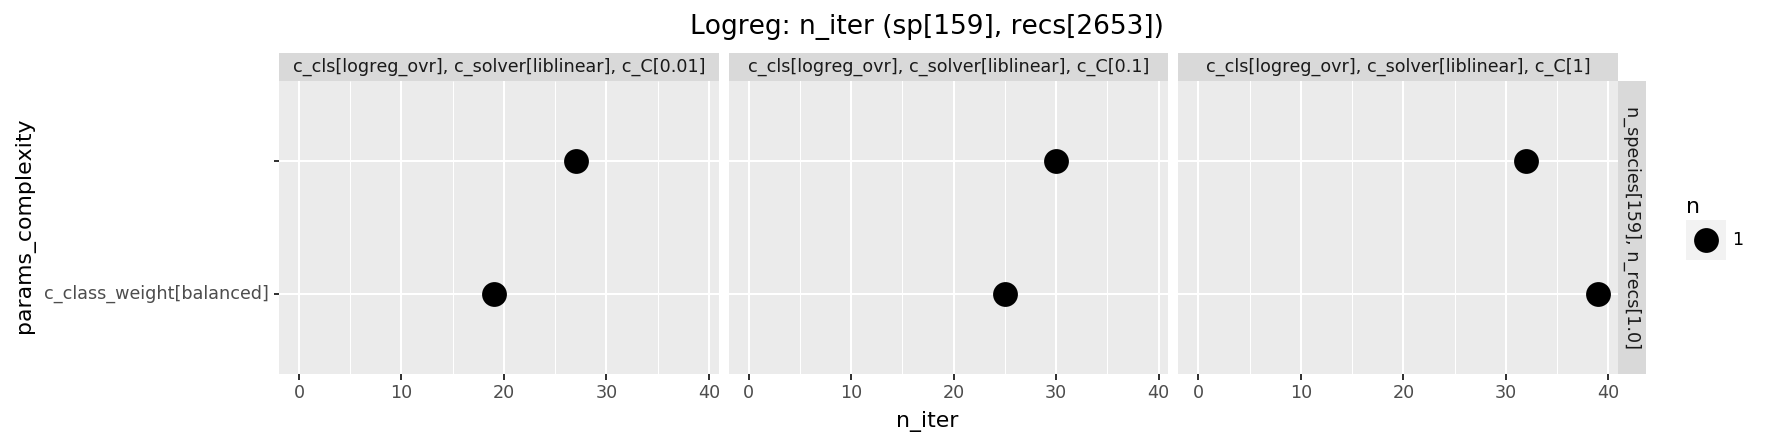

<ggplot: (-9223372036547685060)>

In [ ]:
# Tune logreg n_iter
(cv_models
    .merge(how='left', on='model_id', right=df_flatmap(cv_models, lambda row: (
        dict(model_id=row.model_id, n_iter=n_iter)
        for n_iter in coalesce(row.logreg_n_iter, [0])
    )))
    # Manually compute y.mean() per group
    # .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_count(aes(y='n_iter', size='..n..')) + scale_size_area()
    + expand_limits(y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Logreg: n_iter ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


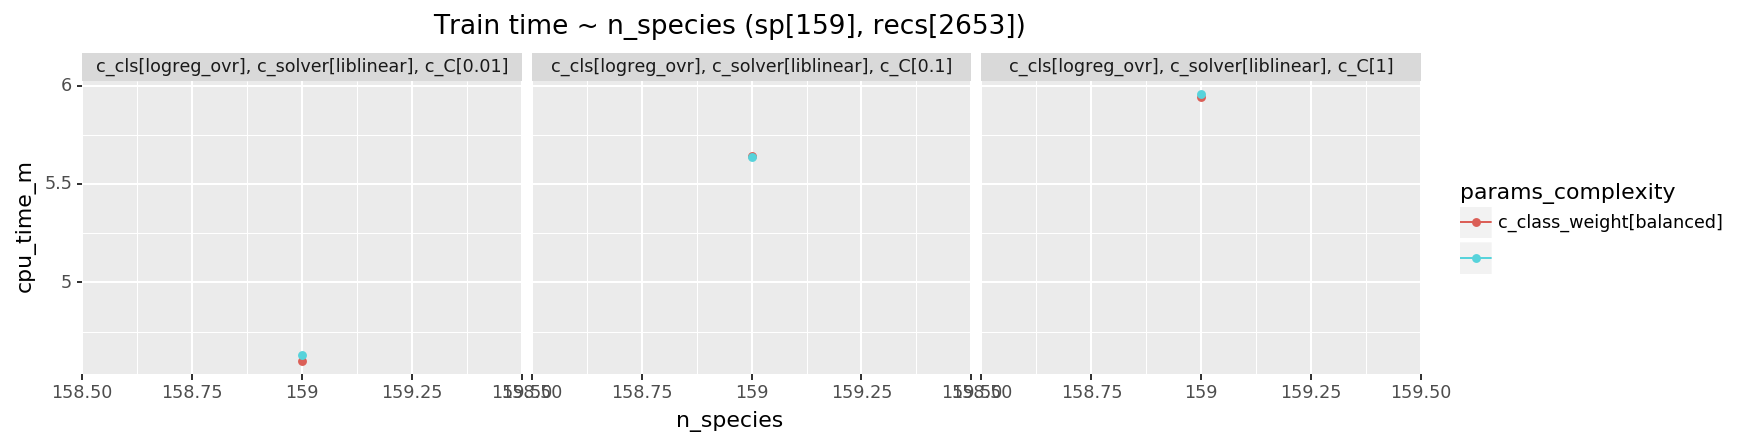

<ggplot: (-9223372036556007217)>

In [ ]:
# Train time ~ n_species
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_species', y='cpu_time_m', color='params_complexity')
    + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_species ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


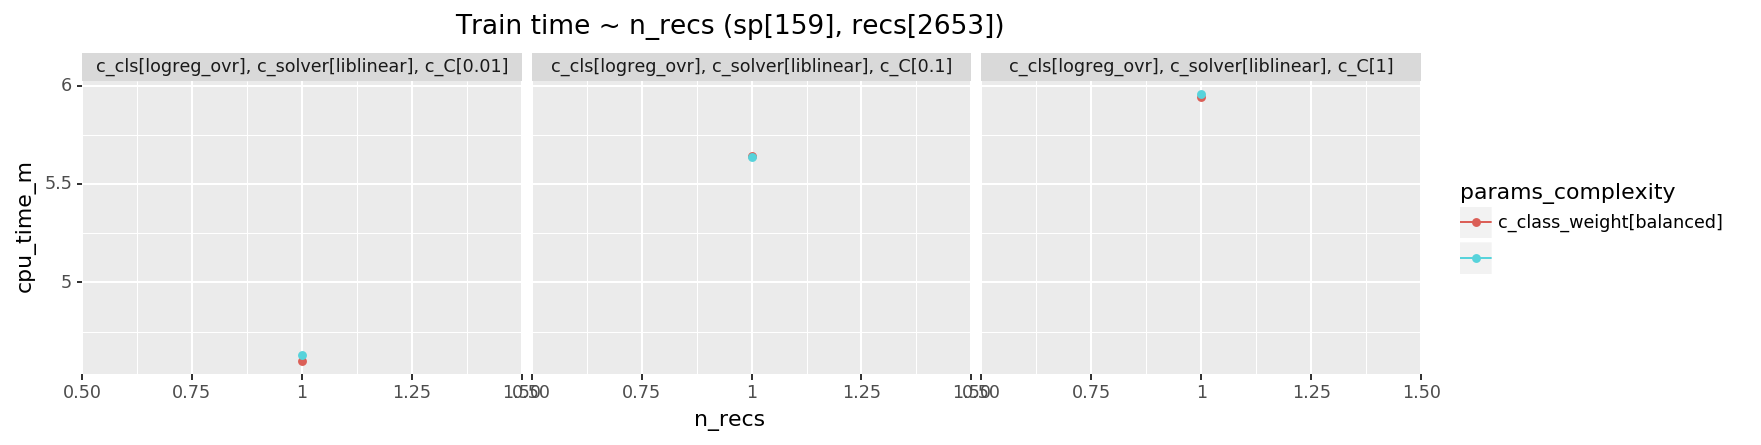

<ggplot: (-9223372036547677885)>

In [ ]:
# Train time ~ n_recs
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_recs', y='cpu_time_m', color='params_complexity')
    + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_recs ({recs_stats})')
)

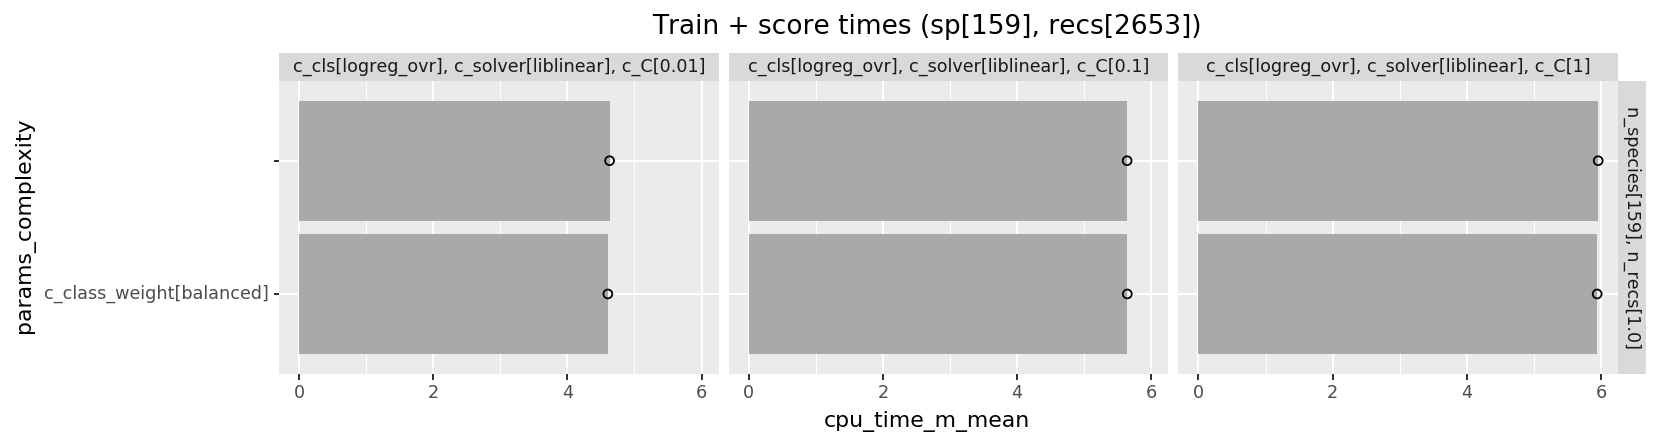

<ggplot: (-9223372036547675511)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='cpu_time_m_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time_m'), color='black', fill='none', size=2)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

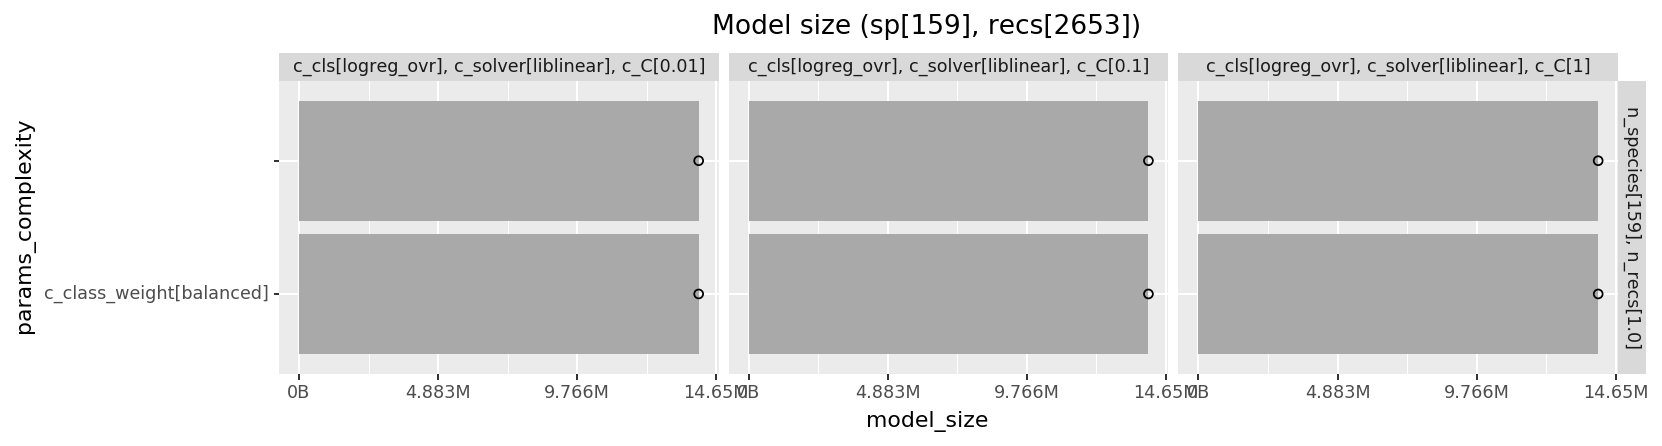

<ggplot: (-9223372036535816269)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([[] if x is None else x.depth for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')
)

[skip]

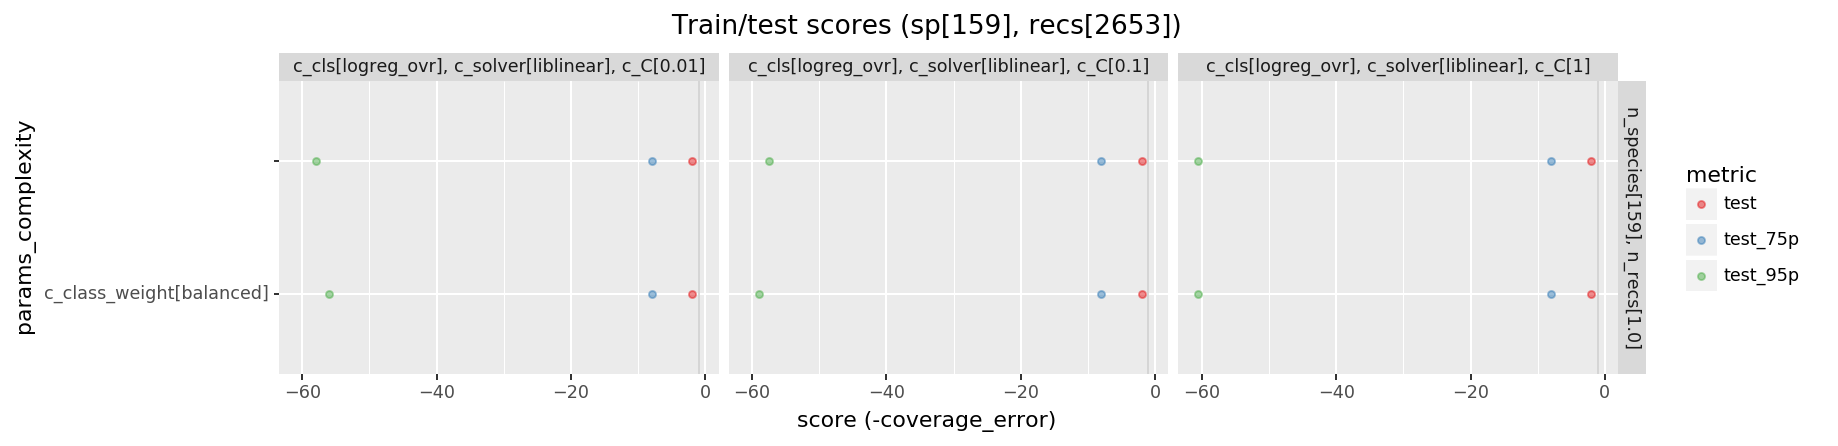

<ggplot: (312164847)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=[
            'params', 'params_data', 'params_model', 'params_complexity',
            'params_data_and_model', 'params_model_and_complexity',
            'n_species', 'n_recs',
            'fold',
        ],
        value_vars=[
            # 'train_score',  # Boring
            'test_score',
            'test_75p_score',
            'test_95p_score',
        ],
        var_name='metric',
        value_name='score'),
    )
    .assign(
        metric=lambda df: df.metric.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.metric, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot)
    + aes(x='params_complexity')
    + aes(y='score')
    + aes(color='metric')
    # + facet_grid('params_data ~ params_model')
    + facet
    + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
    + geom_point(alpha=.5)
    # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
    # + geom_count(aes(size='..n..')) + scale_size_area()
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + coord_flip(
        # ylim=(-40, 0),
    )
    # + scale_color_cmap_d('tab10')
    + scale_color_cmap_d('Set1')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

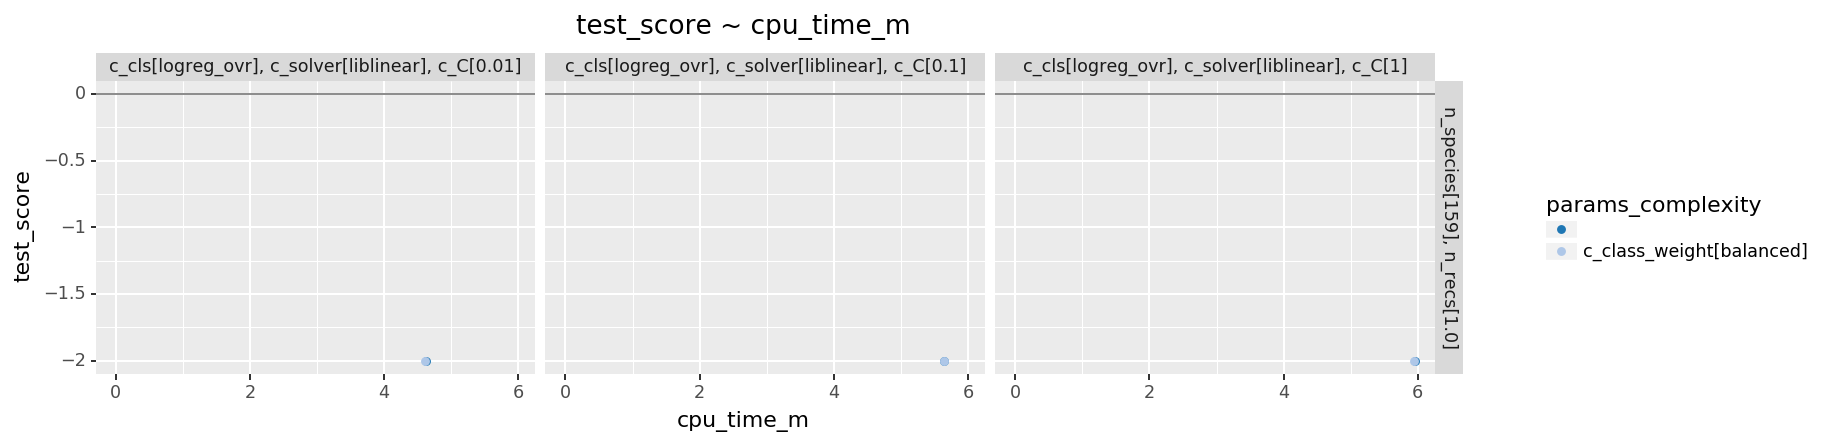

<ggplot: (-9223372036535820919)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time_m', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time_m')
)

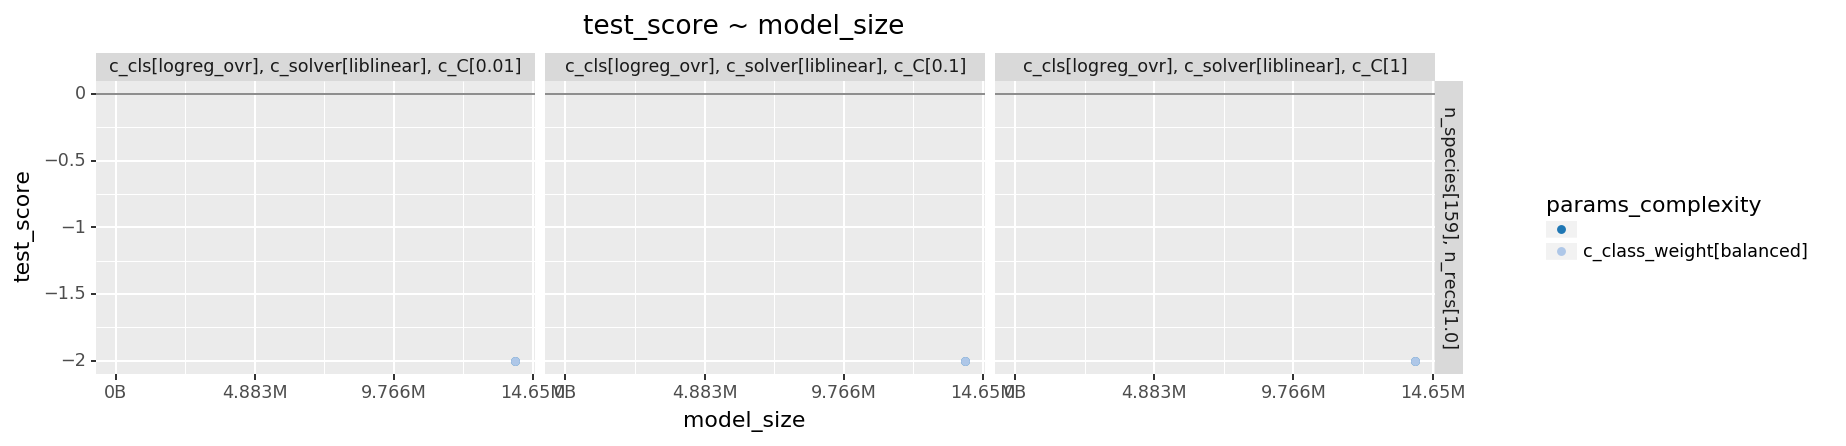

<ggplot: (320675925)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size')
)

In [ ]:
SLOW_PLOTS_NEXT

NameError: name 'SLOW_PLOTS_NEXT' is not defined

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/6]
  fold[*/1]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            params_data_and_model=row.params_data_and_model,
            params_model_and_complexity=row.params_model_and_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
        params_data_and_model=cv_models.params_data_and_model.dtype,
        params_model_and_complexity=cv_models.params_model_and_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
    ))
)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 2/6 [00:00<00:00, 19.31it/s]

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00, 18.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19.20it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,462501,3186,3186,6,NaN,NaN,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1],c_class_weight[balanced], fold[0]"
params,category,433827,3186,3186,6,NaN,NaN,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1],c_class_weight[balanced]"
params_data,category,598968,3186,3186,1,NaN,NaN,"n_species[159], n_recs[1.0]","n_species[159], n_recs[1.0]","n_species[159], n_recs[1.0]","n_species[159], n_recs[1.0]","n_species[159], n_recs[1.0]"
params_model,category,928188,3186,3186,3,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]"
params_complexity,category,360018,3186,3186,2,NaN,NaN,,,,c_class_weight[balanced],c_class_weight[balanced]
params_data_and_model,category,397188,3186,3186,3,NaN,NaN,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[1]","n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[1]"
params_model_and_complexity,category,349398,3186,3186,6,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\nc_class_weight[balanced]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]\n","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]\n","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]\nc_class_weight[balanced]"
fold,int64,76464,3186,3186,1,0.000,0.000,0,0,0,0,0
i,int64,89208,3186,3186,531,1322.507,764.996,3,660,1329,1983,2649


,model_id,params,params_data,params_model,params_complexity,params_data_and_model,params_model_and_complexity,fold,i,y_true,coverage_error
0,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1355,BBFL,2.0
1,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,338,AMBI,1.0
2,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,2516,GTGR,1.0
3,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,2495,TRBL,1.0
4,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1157,MWPW,1.0
5,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1237,RBSA,4.0
6,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,440,NOHA,4.0
7,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,2374,WESP,32.0
8,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[159], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,844,CATE,25.0
9,"n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[159], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[159], n_recs[1.0]","c_cls[logreg_ovr], c_solver[libline

In [ ]:
[print(x) for x in coverage_errors_all_all.params_data.unique()];
params_data = (
    # 'n_species[168], n_recs[1.0]'
    # 'n_species[336], n_recs[1.0]'
    'n_species[159], n_recs[1.0]'
)
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

n_species[159], n_recs[1.0]


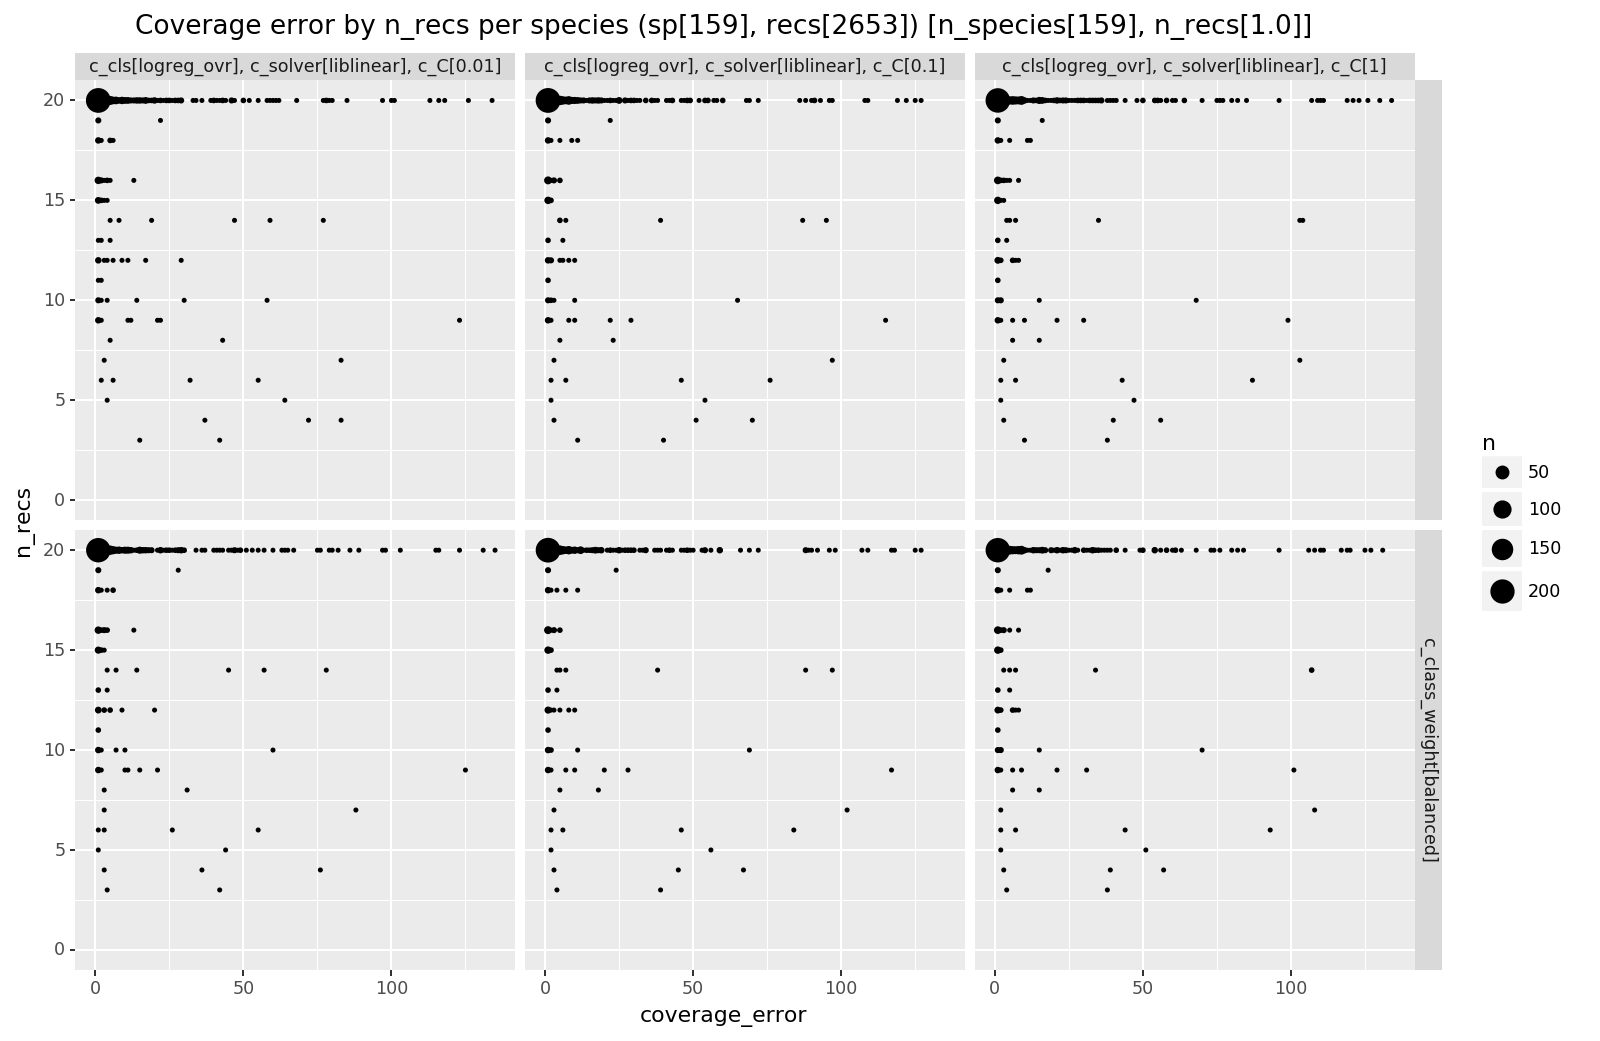

<ggplot: (-9223372036538013429)>

In [ ]:
# TODO Class imbalance
#   1. Is class imbalance causing a problem? [-> maybe]
#   2. Is class_weight solving it? [-> maybe a little bit]
#   - TODO Try again with larger class imbalance
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    .merge(how='left', on='y_true', right=(recs
        .assign(n_recs=1).groupby('species')['n_recs'].sum().reset_index()
        .rename(columns={'species': 'y_true'})
    ))
    # .pipe(puts, f=lambda df: df[:3])  # XXX Debug
    .pipe(ggplot)
    + facet_grid('params_complexity ~ params_model')
    + aes(x='n_recs', y='coverage_error')
    + geom_count(aes(size='..n..')) + scale_size_area()
    + expand_limits(x=0, y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error by n_recs per species ({recs_stats}) [{params_data}]')
)

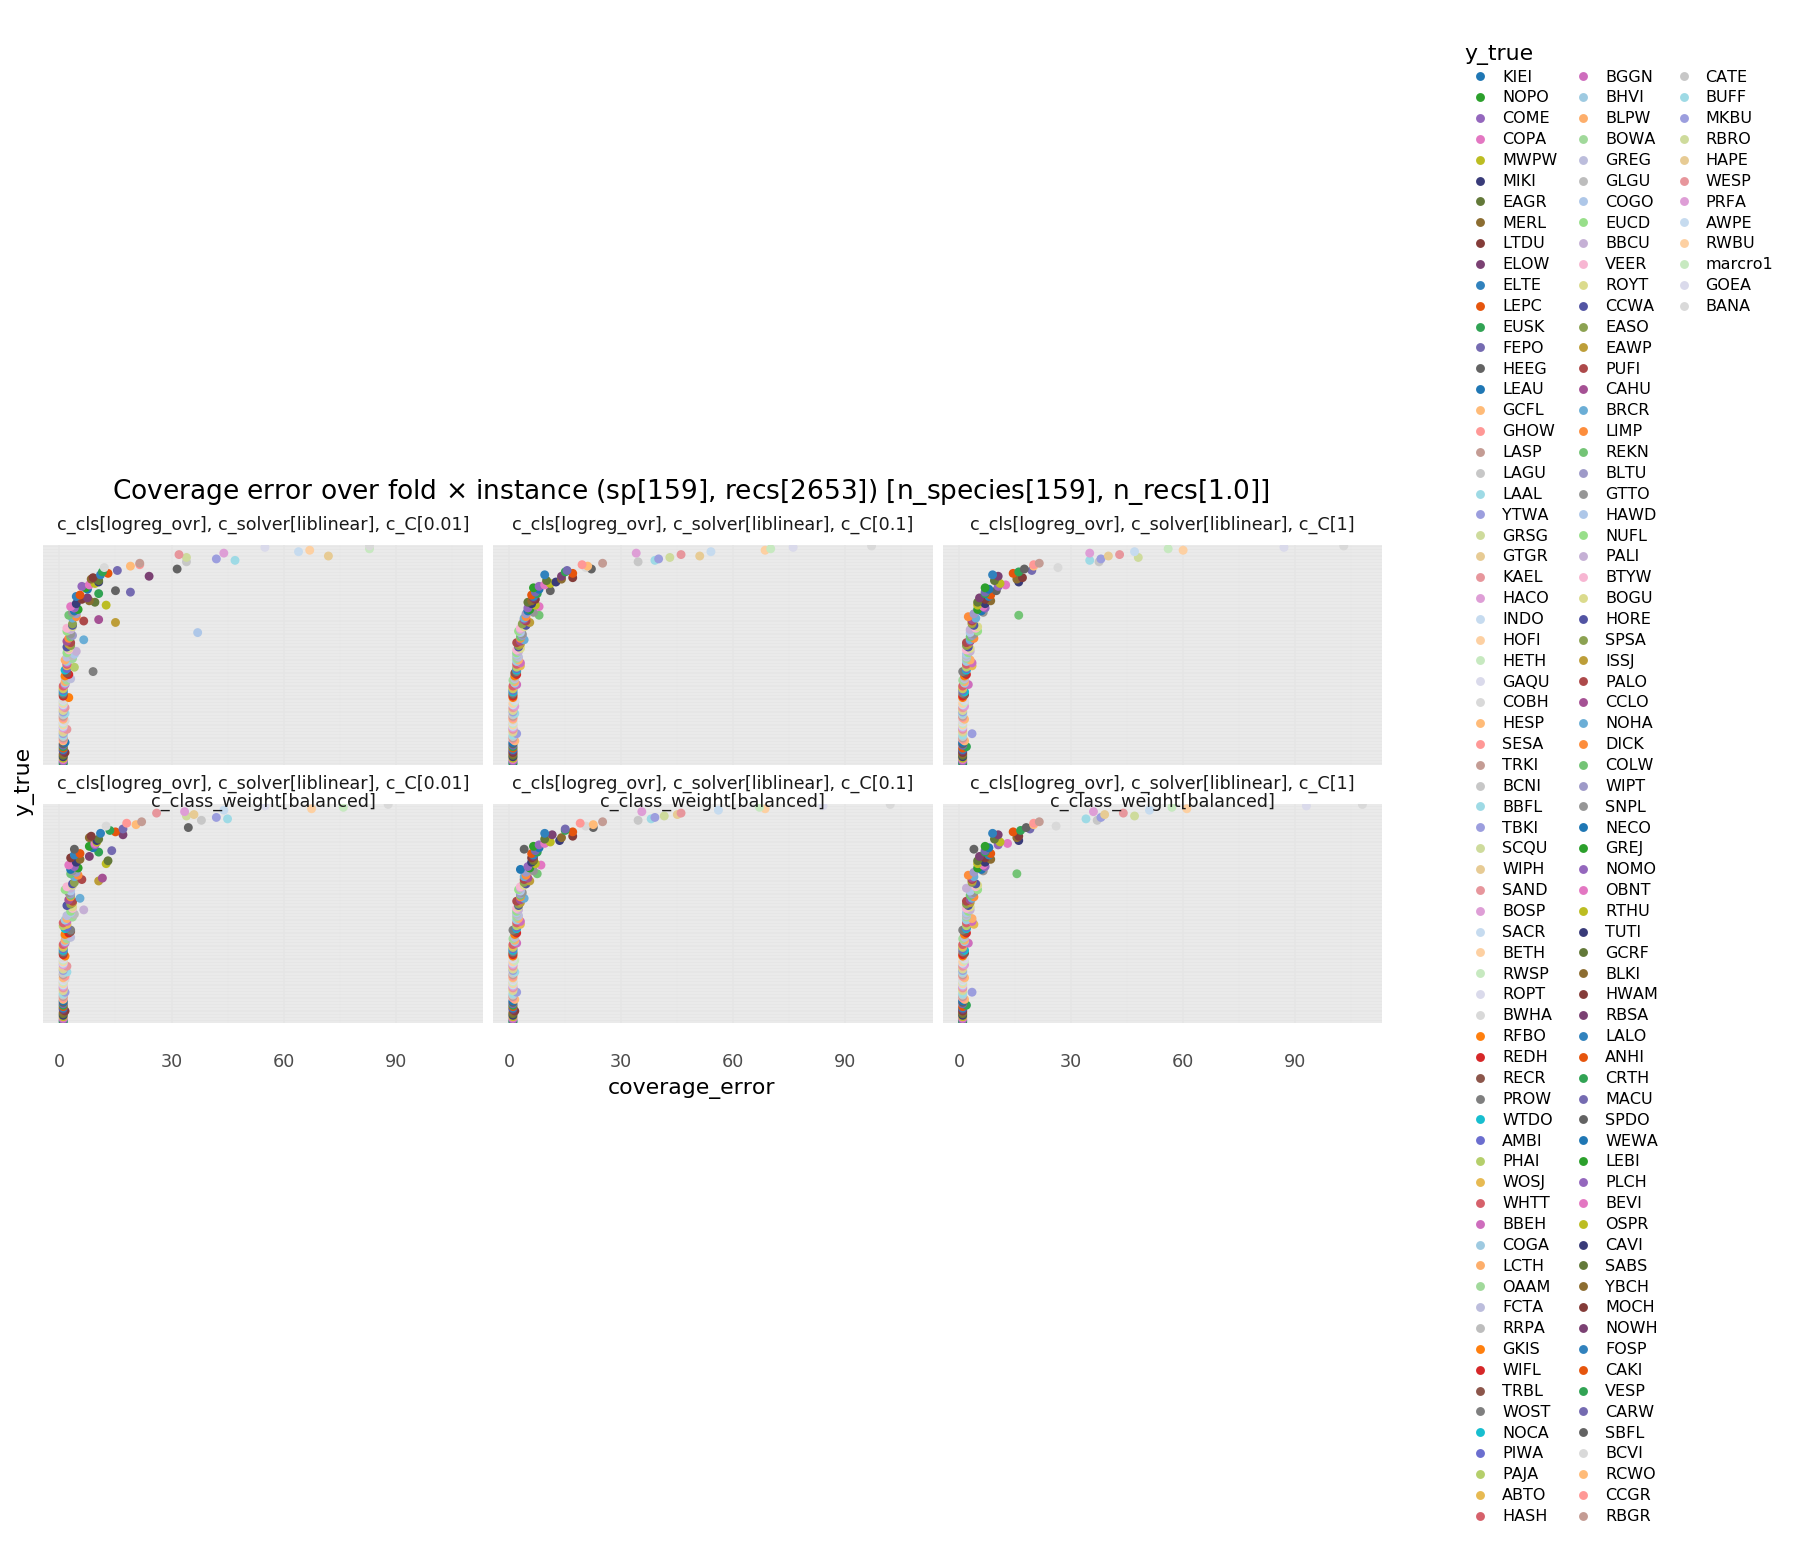

<ggplot: (315379432)>

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    # + facet_grid('params_complexity ~ params_model')
    + facet_wrap('params_model_and_complexity', dir='v',
        nrow=coverage_errors_all_all.params_model.nunique(),  # Bug: nrow instead of ncol [https://github.com/has2k1/plotnine/issues/163]
    )
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12*1, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]
c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]
c_cls[logreg_ovr], c_solver[liblinear], c_C[1]


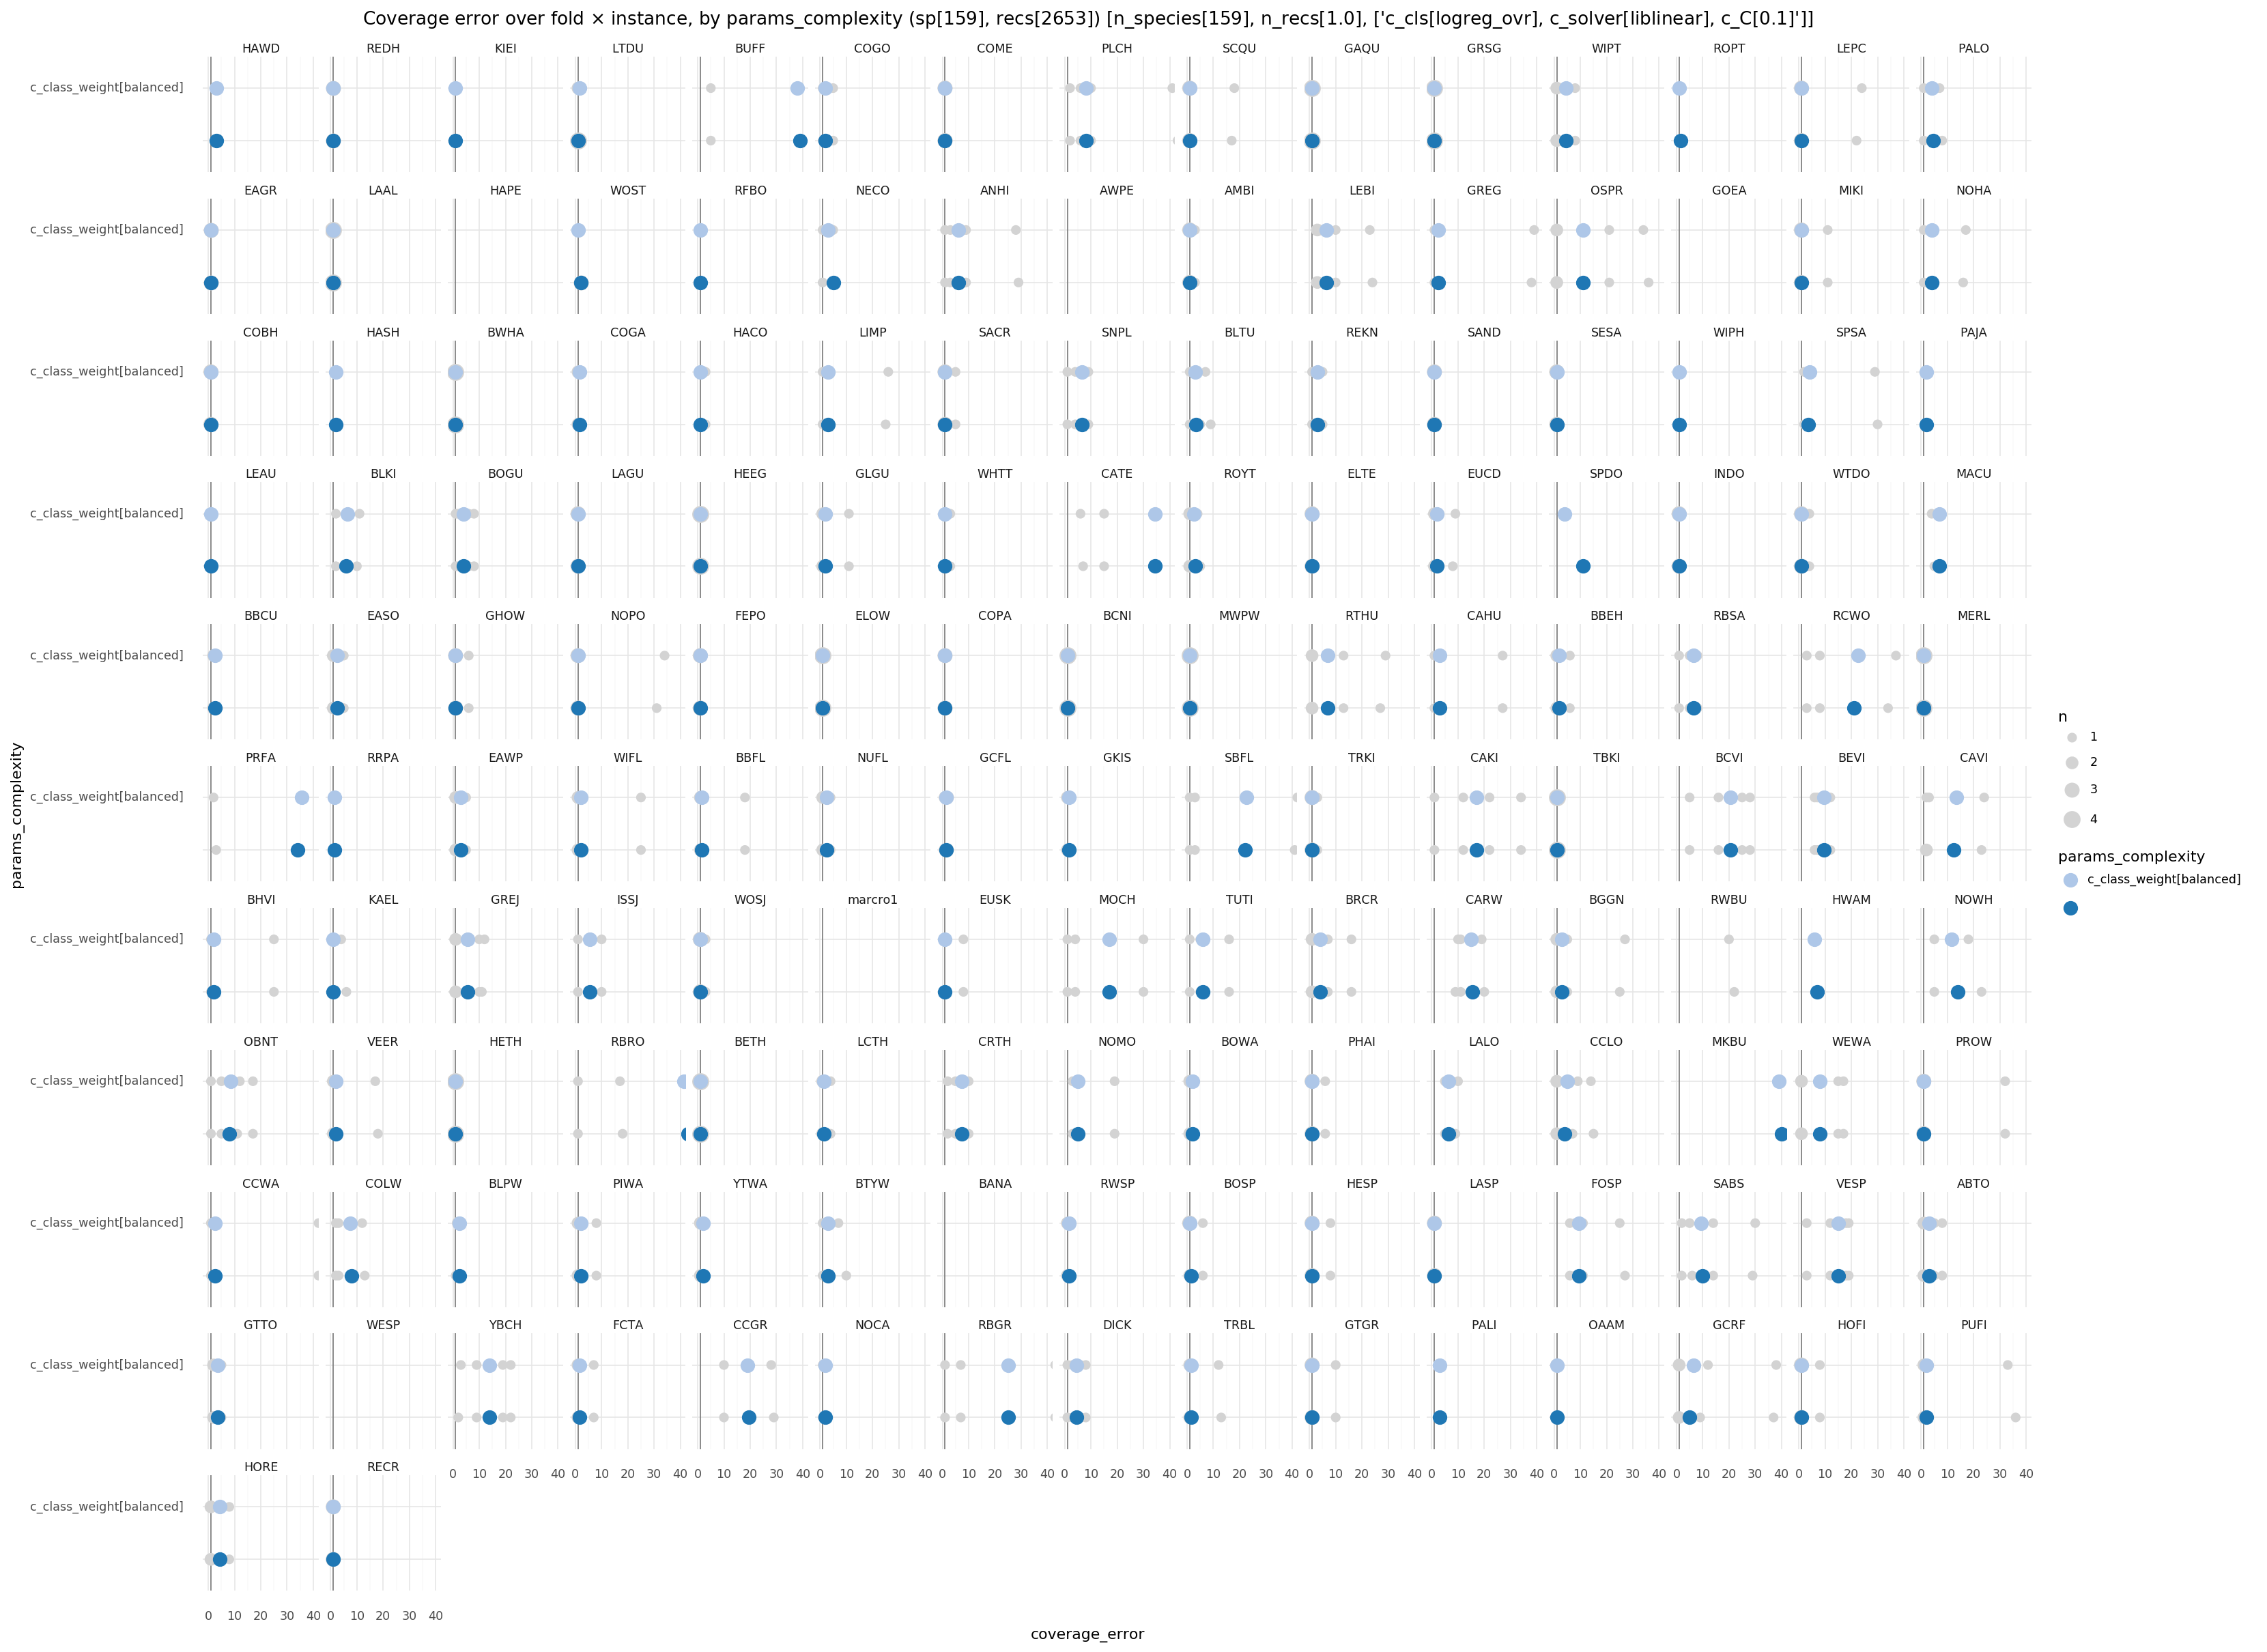

<ggplot: (-9223372036539001386)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_model.unique()];
params_model = [
    # 'c_cls[rf], c_n_estimators[100]',
    # 'c_cls[logreg_multi], c_solver[newton-cg]',
    # 'c_cls[logreg_ovr], c_solver[liblinear]',
    # 'c_cls[xgb_rf], c_n_estimators[100]',
    'c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_model.isin(params_model)]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)


c_class_weight[balanced]


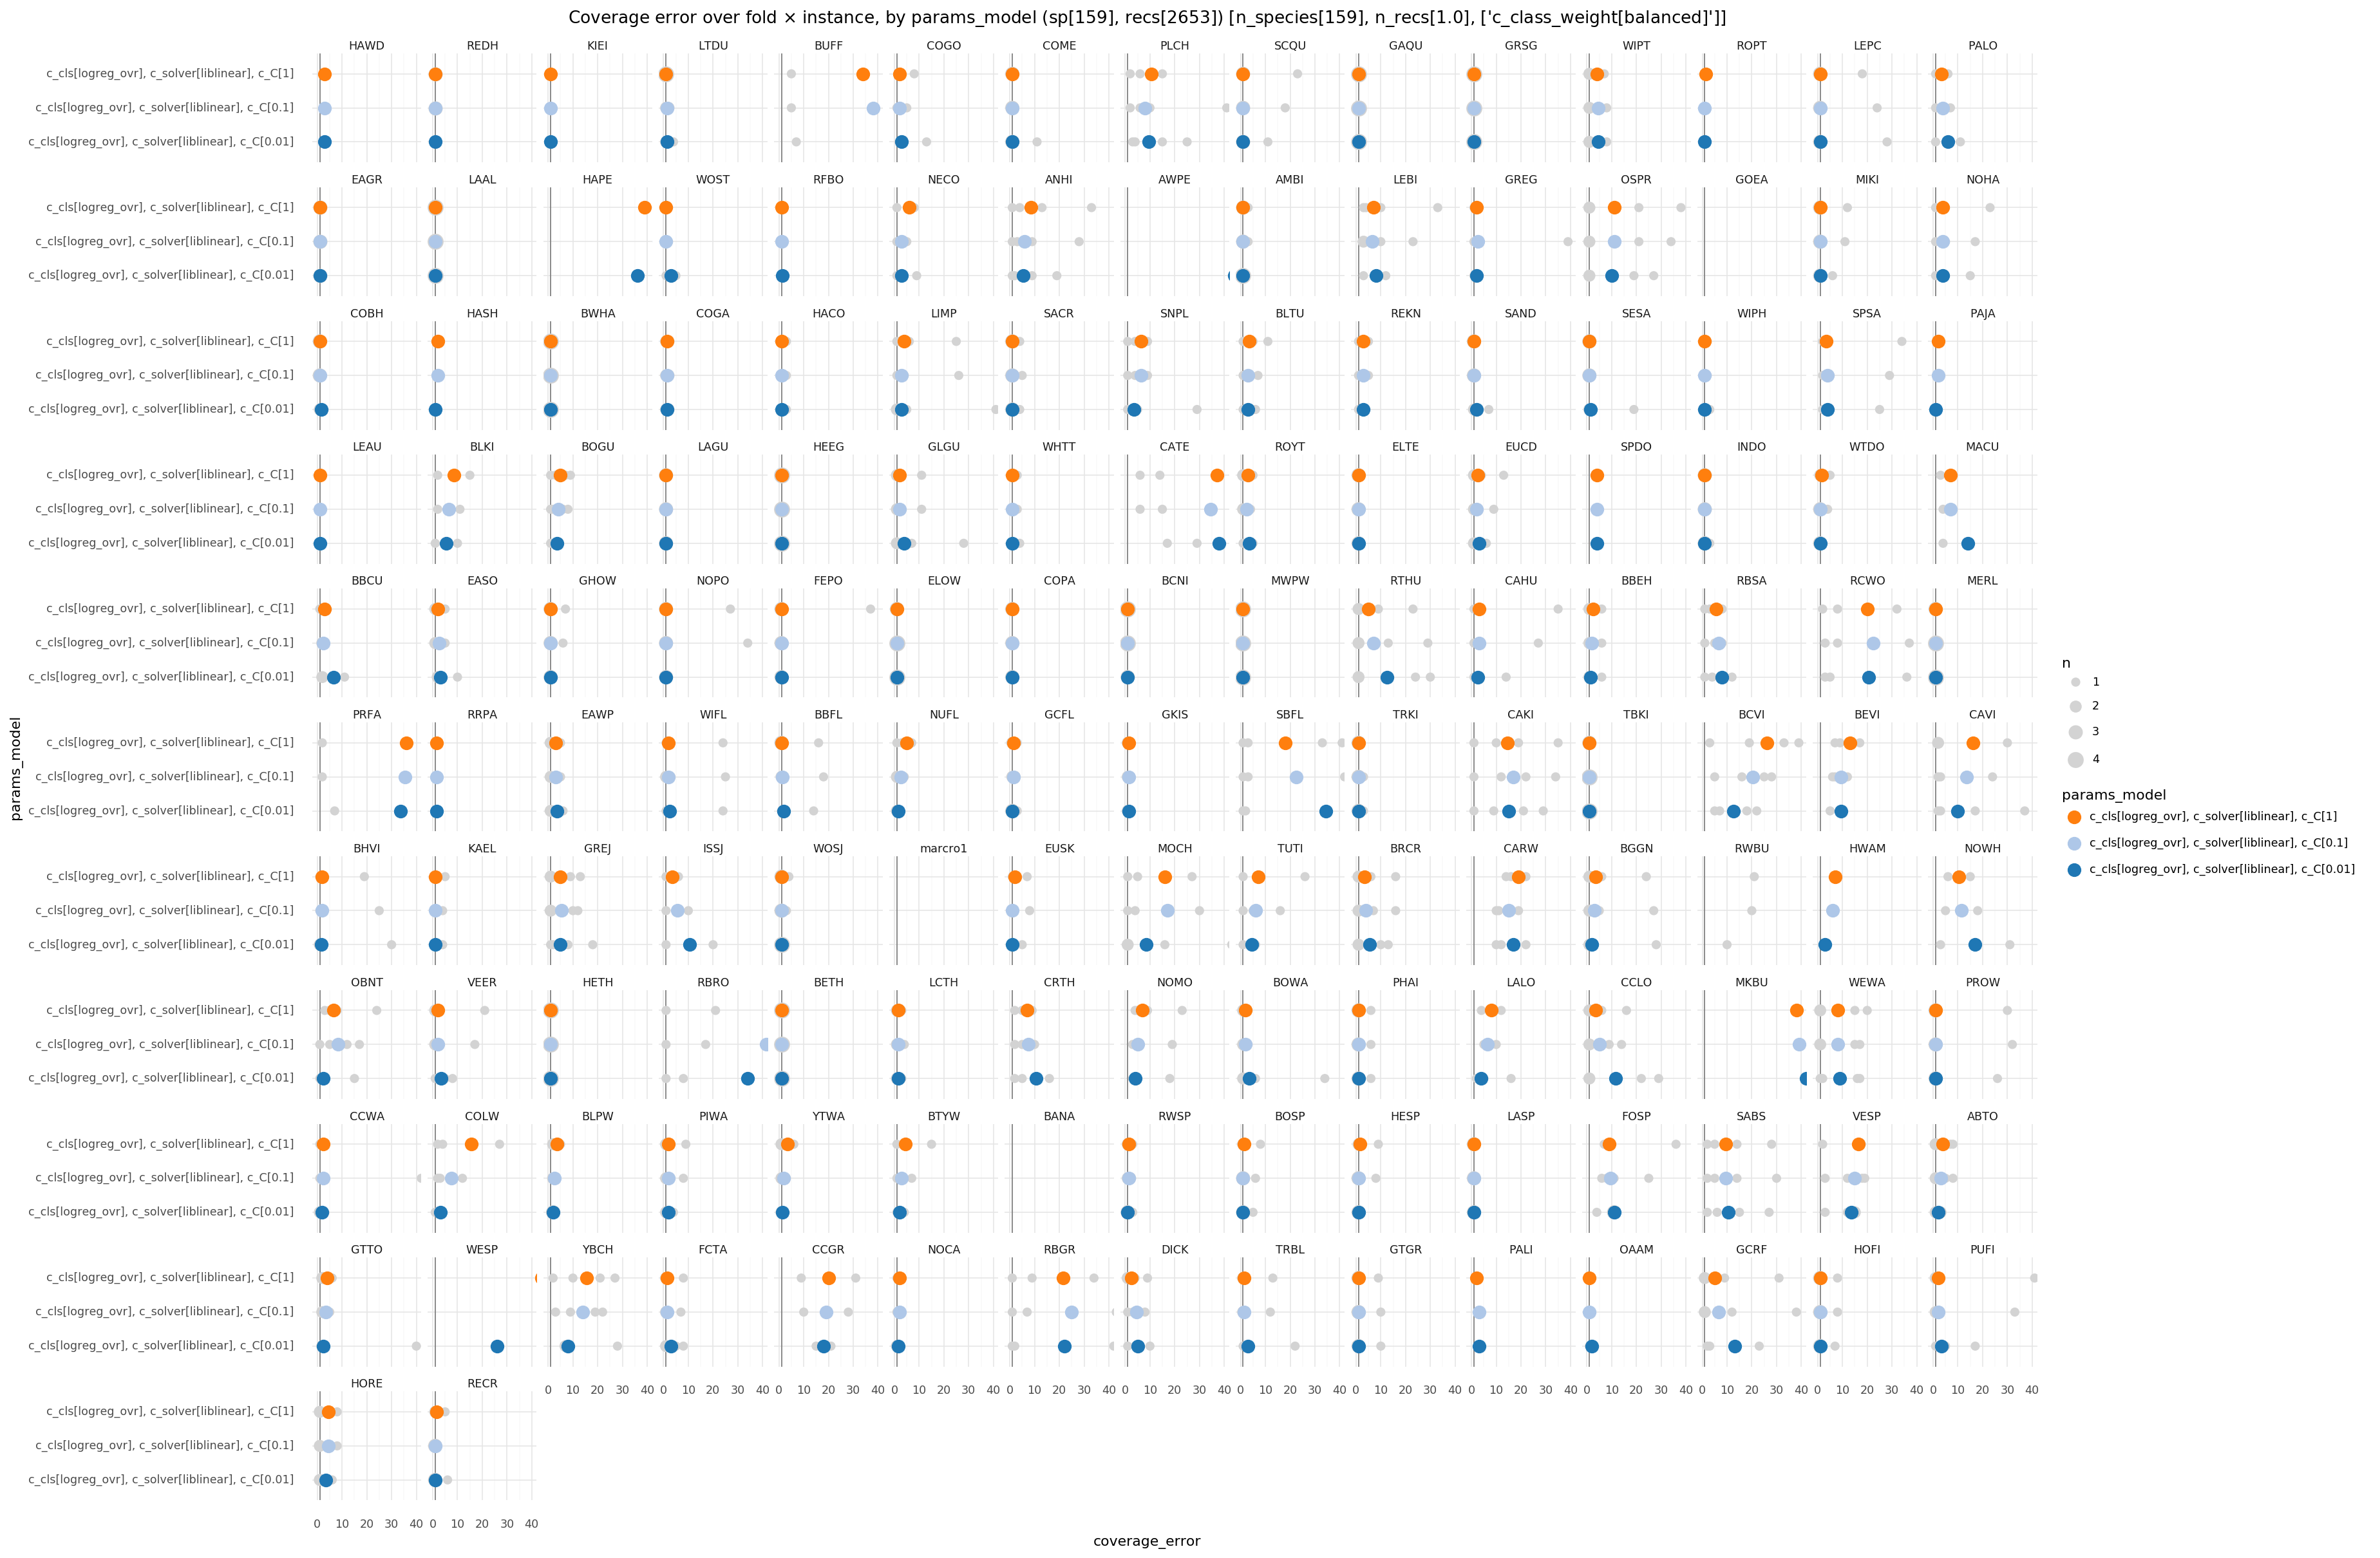

<ggplot: (316943992)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_complexity.unique()];
params_complexity = [
    # 'c_max_depth[46]',
    # 'c_max_depth[1]',
    # 'c_C[0.01]',
    'c_class_weight[balanced]',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity.isin(params_complexity)]
    # [lambda df: df.params.astype(str).str.contains(r'c_n_estimators\[100\]')]  # XXX Subset models
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_complexity}]')
)

In [ ]:
ONE_MODEL_PLOTS_NEXT

# Model diagnostics: one model, all folds

In [ ]:
params_i = 1
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]

In [ ]:
DEBUG_PLOTS_NEXT

# Debug plots, ignored by default

## Debug: resource usage

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

## Debug: RF tuning

In [ ]:
# TODO Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)